# Project Metadata & Copyright Notice

***

## Project Title: <u>ETL of Geo-Temporal Fuzzy Merge for Customer Behaviour using KDTree analysis</u>

<table style="width: 30%; text-align: center; border: 1px solid black;">
    <tr style="font-size: 20px; font-weight: bold;">
        <th>ITEM</th>
        <th>DETAIL</th>
    </tr>
    <tr style="font-size: 16px;">
        <td style="font-weight: bold;">Author</td>
        <td>Shaizam Adil Khan</td>
    </tr>
    <tr style="font-size: 16px;">
        <tr style="font-size: 16px;">
        <td style="font-weight: bold;">Date</td>
        <td>October, 2025</td>
    </tr>
    <tr style="font-size: 16px;">
        <tr style="font-size: 16px;">
        <td style="font-weight: bold;">Version</td>
        <td>1.0</td>
    </tr>
    <tr style="font-size: 16px;">
        <tr style="font-size: 16px;">
        <td style="font-weight: bold;">Report</td>
        <td><a href="https://github.com/shaizamkhan/ETL_Fuzzy_Merge_Supply_Chain_Analysis/blob/main/Shaizam%20Adil%20Khan%20-%20ETL%20pipeline.pdf" target="_blank" style="text-decoration: none; color: blue;">ETL Pipeline report</a></td>
    </tr>
</table>

---

### Copyright & Licensing Information

**© 2025 Shaizam Adil Khan. All rights reserved.**

This notebook and its associated code are provided solely for the purpose of demonstrating technical proficiency and project execution. Unauthorized reproduction, modification, or distribution of this code for commercial purposes is strictly prohibited. For academic or non-commercial use, please credit the original author and the GitHub repository.

**License:** [MIT License](https://mit-license.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

***

# **<u>PROBLEM STATEMENT</u>**

This project addresses a critical challenge in e-commerce analytics: **calculating the precise time elapsed between a customer's initial engagement with our website and their final purchase conversion.**

Our operational data is split across two anonymous datasets:
1.  **Purchase Data:** Contains order details, customer's purchase location (city/country), and the final order timestamp.
2.  **Browsing Behavior Data:** Contains page-view events, IP addresses, and timestamps.

Crucially, **neither dataset shares a unique Customer ID or Order ID.** The challenge is to overcome this missing link using advanced **fuzzy-logic spatial-temporal analysis** to create a unified, high-value dataset.

## Project Goal

The primary goal is to create a unified **Fact Table** capable of calculating the $\mathbf{\text{Browsing-to-Purchase Turnaround Time}}$.

**Key Metrics to be Calculated:**

1.  **Turnaround Time:** The time elapsed between $\mathbf{\text{First\_View\_Timestamp}}$ (Session Start) and $\mathbf{\text{Purchase\_Timestamp}}$ (Conversion).

2.  **Link Confidence:** A flag to categorize the likelihood of the link being accurate (High, Medium, or Low).

3.  **Purchase Efficiency:** A ratio comparing total session interaction (window-shopping) to the final conversion time.

<br>

Let us begin by importing the standard packages for our ETL process and preliminary Exploratory Data Analysis.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

We will now import the raw datasets of [DataCo Smart Supply Chain v5](https://data.mendeley.com/datasets/8gx2fvg2k6/5) provided to us for free and fair use by Mendeley, which we will do so using the standard `wget` method.

In [2]:
# Extract the dataset from the URL
!wget -O /kaggle/working/raw_data.zip 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/8gx2fvg2k6-5.zip'

--2025-10-29 06:51:54--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/8gx2fvg2k6-5.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.116.226, 3.5.66.216, 3.5.69.0, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.116.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26168801 (25M) [application/octet-stream]
Saving to: ‘/kaggle/working/raw_data.zip’

/kaggle/working/raw 100%[===================>]  24.96M  12.1MB/s    in 2.1s    

2025-10-29 06:51:56 (12.1 MB/s) - ‘/kaggle/working/raw_data.zip’ saved [26168801/26168801]



In [3]:
# Set global option to display all rows
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Configure pandas display options to handle large numbers
pd.set_option('display.float_format', '{:.4f}'.format)

In [4]:
# Import dependencies
import zipfile

# Check the contents of the ZIP file
with zipfile.ZipFile('/kaggle/working/raw_data.zip', 'r') as zip_ref:
    # Print the contents
    zip_ref.printdir()

    # Extract the dataset into a new directory
    zip_ref.extractall('/kaggle/working/extracted_files/')

File Name                                             Modified             Size
tokenized_access_logs.csv                      2020-02-13 14:19:54     95446364
DataCoSupplyChainDataset.csv                   2020-02-13 14:19:58     95910149
DescriptionDataCoSupplyChain.csv               2020-02-13 14:20:04         3444


The data is a combination of 3 dataset files, each with the following information:

1. **`tokenized_access_logs.csv`** contains the customer **'browsing'** behaviour for the store, such as the URLs accessed, the IP address used to browse, the department accessed from the URL, and the timestamp of the access to that URL. It basically has the entire browsing log of every IP address that ever visited the store in the given timeframe.

2. **`DataCoSupplyChainDataset.csv`** contains the raw **'purchase'** information for the store, including the address details of the purchase, the store details and the order address, along with the status of the order fulfilment, among other details. The full dataset features will be displayed below from the dataset description file.

3. **`DataCoSupplyChainDataset.csv`** contains the variable description for the variables used in the raw purchase detail dataset. However, there are none for the customer browsing behavior provided in the access logs, due to which liberties have been taken to assume the variables used in the dataframe.

In [5]:
# Wrap text of Jupyter cell columns as per visibility
from IPython.display import display, HTML
def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

In [6]:
# Extract the data description as DataFrame
data_desc = pd.read_csv('/kaggle/working/extracted_files/DescriptionDataCoSupplyChain.csv')

# Correct the data field descriptions
# Remove the ':' in the DESCRIPTION column
data_desc.loc[:, 'DESCRIPTION'] = data_desc.loc[:, 'DESCRIPTION'].replace({':': ''}, regex = True)

# Remove the white spaces to the left and right of the field names
data_desc.loc[:, 'FIELDS'] = data_desc.loc[:, 'FIELDS'].str.strip()

#Use the dataframe defined for the below code
data_desc.loc[:, 'DESCRIPTION'] = data_desc.loc[:, 'DESCRIPTION'].str.wrap(90) 
wrap_df_text(data_desc)

,FIELDS,DESCRIPTION
0,Type,Type of transaction made
1,Days for shipping (real),Actual shipping days of the purchased product
2,Days for shipment (scheduled),Days of scheduled delivery of the purchased product
3,Benefit per order,Earnings per order placed
4,Sales per customer,Total sales per customer made per customer
5,Delivery Status,"Delivery status of orders Advance shipping , Late delivery , Shipping canceled ,Shipping on time"
6,Late_delivery_risk,"Categorical variable that indicates if sending is late (1), it is not late (0)."
7,Category Id,Product category code
8,Category Name,Description of the product category
9,Customer City,City where the customer made the purchase


In [7]:
# Check the encoding of the dataset to avoid errors
import chardet
with open("/kaggle/working/extracted_files/DataCoSupplyChainDataset.csv",
          "rb") as f:
   result = chardet.detect(f.read())
   print(result["encoding"])

Windows-1252


In [8]:
# Extract the structured dataset
cust_order = pd.read_csv('/kaggle/working/extracted_files/DataCoSupplyChainDataset.csv',
                         encoding = 'Windows-1252', encoding_errors = 'replace')

cust_order.columns = (cust_order.columns
                     .str.strip()
                     .str.replace('(', '')
                     .str.replace(')', '')
                     .str.replace(' ', '_'))

cust_order.head()

,Type,Days_for_shipping_real,Days_for_shipment_scheduled,Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,Customer_Country,Customer_Email,Customer_Fname,Customer_Id,Customer_Lname,Customer_Password,Customer_Segment,Customer_State,Customer_Street,Customer_Zipcode,Department_Id,Department_Name,Latitude,Longitude,Market,Order_City,Order_Country,Order_Customer_Id,order_date_DateOrders,Order_Id,Order_Item_Cardprod_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Product_Price,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Item_Total,Order_Profit_Per_Order,Order_Region,Order_State,Order_Status,Order_Zipcode,Product_Card_Id,Product_Category_Id,Product_Description,Product_Image,Product_Name,Product_Price,Product_Status,shipping_date_DateOrders,Shipping_Mode
0,DEBIT,3,4,91.2500,314.6400,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0000,2,Fitness,18.2515,-66.0371,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.1100,0.0400,180517,327.7500,0.2900,1,327.7500,314.6400,91.2500,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.0900,311.3600,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0000,2,Fitness,18.2795,-66.0371,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.3900,0.0500,179254,327.7500,-0.8000,1,327.7500,311.3600,-249.0900,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.7800,309.7200,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0000,2,Fitness,37.2922,-121.8813,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.0300,0.0600,179253,327.7500,-0.8000,1,327.7500,309.7200,-247.7800,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.8600,304.8100,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0000,2,Fitness,34.1259,-118.2910,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.9400,0.0700,179252,327.7500,0.0800,1,327.7500,304.8100,22.8600,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.2100,298.2500,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0000,2,Fitness,18.2538,-66.0370,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.5000,0.0900,179251,327.7500,0.4500,1,327.7500,298.2500,134.2100,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/15/2018 11:24,Standard Class


In [9]:
# Extract the unstructured dataset
cust_behv = pd.read_csv('/kaggle/working/extracted_files/tokenized_access_logs.csv',
                         encoding = 'Windows-1252', encoding_errors = 'replace')
cust_behv.head()

,Product,Category,Date,Month,Hour,Department,ip,url
0,adidas Brazuca 2017 Official Match Ball,baseball & softball,9/1/2017 6:00,Sep,6,fitness,37.97.182.65,/department/fitness/category/baseball%20&%20softball/product/adidas%20Brazuca%202017%20Official%20Match%20Ball
1,The North Face Women's Recon Backpack,hunting & shooting,9/1/2017 6:00,Sep,6,fan shop,206.56.112.1,/department/fan%20shop/category/hunting%20&%20shooting/product/The%20North%20Face%20Women's%20Recon%20Backpack
2,adidas Kids' RG III Mid Football Cleat,featured shops,9/1/2017 6:00,Sep,6,apparel,215.143.180.0,/department/apparel/category/featured%20shops/product/adidas%20Kids'%20RG%20III%20Mid%20Football%20Cleat
3,Under Armour Men's Compression EV SL Slide,electronics,9/1/2017 6:00,Sep,6,footwear,206.56.112.1,/department/footwear/category/electronics/product/Under%20Armour%20Men's%20Compression%20EV%20SL%20Slide
4,Pelican Sunstream 100 Kayak,water sports,9/1/2017 6:01,Sep,6,fan shop,136.108.56.242,/department/fan%20shop/category/water%20sports/product/Pelican%20Sunstream%20100%20Kayak


## PRELIMINARY ANALYSIS

We will first check the raw data to understand the distribution of the dataset, as well as check if any sort of data cleaning is to be carried out on the dataset. As often the case with many dataset, the data may have a lot of bad and/or missing values which either necessitates the column to be dropped, or the values to be corrected based on the description of the variable, such as inferring the country from the city for example.

In [10]:
# Let us check the basic info for each of the datasets
display(cust_order.info())
display(cust_behv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Type                         180519 non-null  object 
 1   Days_for_shipping_real       180519 non-null  int64  
 2   Days_for_shipment_scheduled  180519 non-null  int64  
 3   Benefit_per_order            180519 non-null  float64
 4   Sales_per_customer           180519 non-null  float64
 5   Delivery_Status              180519 non-null  object 
 6   Late_delivery_risk           180519 non-null  int64  
 7   Category_Id                  180519 non-null  int64  
 8   Category_Name                180519 non-null  object 
 9   Customer_City                180519 non-null  object 
 10  Customer_Country             180519 non-null  object 
 11  Customer_Email               180519 non-null  object 
 12  Customer_Fname               180519 non-null  object 
 13 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469977 entries, 0 to 469976
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Product     469977 non-null  object
 1   Category    469977 non-null  object
 2   Date        469977 non-null  object
 3   Month       469977 non-null  object
 4   Hour        469977 non-null  int64 
 5   Department  469977 non-null  object
 6   ip          469977 non-null  object
 7   url         469977 non-null  object
dtypes: int64(1), object(7)
memory usage: 28.7+ MB


None

From the above analysis, we can see that the purchase data has two columns that have very high proportion of missing values, viz., the `Product_Description` column (with 100% missing values) and the `Order_Zipcode` column (with over 80% missing values). However, since we are working to merge the datasets, we will perform the data cleaning operations AFTER the merge has occured, as the merge will be done using Geo-coding APIs, which may help in inferring the missing values later on.

Let us try to homogenise the Category naming scheme across both the datasets, which we may then use for matching the entry before merging.

In [11]:
# Custom function to capitalize each word except 's in Category
def capitalize_except_s(text):
    return ' '.join([word.capitalize() if word.lower() != "'s" else word for word in text.split()])

In [12]:
from IPython.display import Markdown
display(Markdown('## Customer Browsing Categories:'))
display(cust_behv.loc[:, 'Category'].apply(capitalize_except_s).unique())
print('\n')
display(Markdown('## Customer Purchase Categories:'))
display(cust_order.loc[:, 'Category_Name'].unique())

## Customer Browsing Categories:

array(['Baseball & Softball', 'Hunting & Shooting', 'Featured Shops',
       'Electronics', 'Water Sports', 'Accessories', 'Basketball',
       "Women's Apparel", 'Boxing & Mma', 'Cleats',
       'Indoor Outdoor Games', 'Fitness Accessories', 'Strength Training',
       'Tennis & Racquet', 'Lacrosse', 'Cardio Equipment', 'Soccer',
       "Girls' Apparel", 'Fishing', 'Shop By Sport', 'Golf Bags & Carts',
       'Hockey', "Men's Footwear", 'Golf Gloves', "Kids' Golf Clubs",
       'As Seen On Tv!', 'Golf Shoes', 'Golf Balls', 'Trade-in',
       'Camping & Hiking', "Women's Golf Clubs", 'Golf Apparel',
       "Men's Golf Clubs"], dtype=object)

## Customer Purchase Categories:

array(['Sporting Goods', 'Cleats', 'Shop By Sport', "Women's Apparel",
       'Electronics', 'Boxing & MMA', 'Cardio Equipment', 'Trade-In',
       "Kids' Golf Clubs", 'Hunting & Shooting', 'Baseball & Softball',
       "Men's Footwear", 'Camping & Hiking', 'Consumer Electronics',
       'Cameras ', 'Computers', 'Basketball', 'Soccer', "Girls' Apparel",
       'Accessories', "Women's Clothing", 'Crafts', "Men's Clothing",
       'Tennis & Racquet', 'Fitness Accessories', 'As Seen on  TV!',
       'Golf Balls', 'Strength Training', "Children's Clothing",
       'Lacrosse', 'Baby ', 'Fishing', 'Books ', 'DVDs', 'CDs ', 'Garden',
       'Hockey', 'Pet Supplies', 'Health and Beauty', 'Music',
       'Video Games', 'Golf Gloves', 'Golf Bags & Carts', 'Golf Shoes',
       'Golf Apparel', "Women's Golf Clubs", "Men's Golf Clubs", 'Toys',
       'Water Sports', 'Indoor/Outdoor Games'], dtype=object)

## GEOCODING LOOKUP

From the preliminary observation of the dataset variables, the fundamental challenge of this ETL project is the *absence of a **shared primary key*** between the Purchase Data and the Browsing Behavior Data. Since we cannot link Customer ID to an anonymous browsing session IP, the only viable connection is a **spatial-temporal fuzzy join** which requires converting all location-based identifiers into uniform, mathematically comparable coordinates.

### Why Geocoding?

Geocoding is the process of converting textual or network addresses (like 'Customer City, Country' or an IP Address) into precise geographic coordinates (Latitude and Longitude). This conversion transforms the linking problem from a search for an exact string match (which is highly unreliable) into a calculation of physical proximity, which is the only reliable basis for attributing an anonymous session to a final purchase. Without this step, the core metric (Turnaround Time) would be impossible to calculate for the 0.08% of traceable customers.

<br>

For our process, we have used the [ip-api app](https://ip-api.com/) to obtain the geo-coded results from the IP browsing sessions. These results will later be used to match the geo-coded values from the city of purchase.

In [13]:
# Import dependencies
import requests
import time
from tqdm import tqdm

# Test with a single IP first
test_ip = cust_behv.loc[0, 'ip']
test_url = f"http://ip-api.com/json/{test_ip}?fields=status,message,country,regionName,city,zip,lat,lon,query"

response = requests.get(test_url, data={})
print(f"Test response status: {response.status_code}")
display(response.json())

Test response status: 200


{'status': 'success',
 'country': 'The Netherlands',
 'regionName': 'Utrecht',
 'city': 'Houten',
 'zip': '3994',
 'lat': 52.0223,
 'lon': 5.1895,
 'query': '37.97.182.65'}

In [14]:
# Create function to process each IP address
def get_coordinates(ip):
    """
    Fetch latitude, longitude, city and country for a given IP
    using ipinfo.io API
    Returns (lat, lon, city, country) pandas Series or 
    (None, None, None, None) if lookup fails.
    """
    try:
        url = f"http://ip-api.com/json/{ip}?fields=status,message,country,regionName,city,zip,lat,lon,proxy,query"
        response = requests.get(url, timeout=5)
        data = response.json()

        if all(field in data for field in ['lat', 'lon', 'city', 'country']):
            return pd.Series({
                'browse_lat': float(data['lat']),
                'browse_long': float(data['lon']),
                'browse_city': str(data['city']),
                'browse_country': str(data['country'])
            })
    except Exception as e:
        print(f'No geocoding for {ip}: {e}')
    
    # Return default values if lookup fails
    return pd.Series({
        'browse_lat': None,
        'browse_long': None, 
        'browse_city': None,
        'browse_country': None
    })

In [15]:
# Check for the first browsing session
get_coordinates(cust_behv.loc[0, 'ip'])

browse_lat                52.0223
browse_long                5.1895
browse_city                Houten
browse_country    The Netherlands
dtype: object

In [16]:
# Get unique IPs
unique_ips = cust_behv.loc[:, 'ip'].unique()

# Process and create geo DataFrame in one go
geo_data_list = list()

for ip in tqdm(unique_ips, desc="Fetching coordinates"):
    geo_data_list.append(get_coordinates(ip).to_dict())
    time.sleep(1.6)

# Create DataFrame and merge (most efficient)
geo_df = pd.DataFrame(geo_data_list)
geo_df.loc[:, 'ip'] = unique_ips  # Add IP column for merging
geo_df.head()

Fetching coordinates: 100%|██████████| 3340/3340 [1:30:38<00:00,  1.63s/it]


,browse_lat,browse_long,browse_city,browse_country,ip
0,52.0223,5.1895,Houten,The Netherlands,37.97.182.65
1,44.8642,-92.9966,Newport,United States,206.56.112.1
2,39.9819,-82.9048,Columbus,United States,215.143.180.0
3,32.8771,-80.0130,North Charleston,United States,136.108.56.242
4,50.4777,12.3649,Falkenstein,Germany,116.202.25.156


In [17]:
# Merge back to original data
cust_behv = cust_behv.merge(geo_df, on='ip', how='left')

print("IP Geolocation Completed!")

IP Geolocation Completed!


In [18]:
cust_behv.head()

,Product,Category,Date,Month,Hour,Department,ip,url,browse_lat,browse_long,browse_city,browse_country
0,adidas Brazuca 2017 Official Match Ball,baseball & softball,9/1/2017 6:00,Sep,6,fitness,37.97.182.65,/department/fitness/category/baseball%20&%20softball/product/adidas%20Brazuca%202017%20Official%20Match%20Ball,52.0223,5.1895,Houten,The Netherlands
1,The North Face Women's Recon Backpack,hunting & shooting,9/1/2017 6:00,Sep,6,fan shop,206.56.112.1,/department/fan%20shop/category/hunting%20&%20shooting/product/The%20North%20Face%20Women's%20Recon%20Backpack,44.8642,-92.9966,Newport,United States
2,adidas Kids' RG III Mid Football Cleat,featured shops,9/1/2017 6:00,Sep,6,apparel,215.143.180.0,/department/apparel/category/featured%20shops/product/adidas%20Kids'%20RG%20III%20Mid%20Football%20Cleat,39.9819,-82.9048,Columbus,United States
3,Under Armour Men's Compression EV SL Slide,electronics,9/1/2017 6:00,Sep,6,footwear,206.56.112.1,/department/footwear/category/electronics/product/Under%20Armour%20Men's%20Compression%20EV%20SL%20Slide,44.8642,-92.9966,Newport,United States
4,Pelican Sunstream 100 Kayak,water sports,9/1/2017 6:01,Sep,6,fan shop,136.108.56.242,/department/fan%20shop/category/water%20sports/product/Pelican%20Sunstream%20100%20Kayak,32.8771,-80.0130,North Charleston,United States


Now, although we have successfully obtained the geo-codes from the browsing IP addresses of each session, we need to understand that the potential customer may not be browsing from his personal device. There could be other factors that come into play, such as private IP addresses which are tied to private ISP providers, confidential IP addresses tied to businesses as well as invalid IP addresses that may come from using proxies (in case of web-crawlers and scrapers).

We will thus, isolate these cases and, depending on the proportion of such addresses, will either drop the same, or see if any other information can be garnered from other features.

In [19]:
# Check the missing results in your dataframe
null_coords = cust_behv[cust_behv['browse_lat'].isna() | cust_behv['browse_long'].isna()]
print(f"Rows with missing coordinates: {len(null_coords)}")

if len(null_coords) > 0:
    print("\nSample rows with missing coordinates:")
    print(null_coords[['ip', 'browse_lat', 'browse_long']].head())
    
    # Check which IPs failed
    failed_ips = null_coords['ip'].unique()
    print(f"\nUnique IPs that failed geocoding: {len(failed_ips)}")
    print(f"Sample failed IPs: {failed_ips[:5]}")

Rows with missing coordinates: 4586

Sample rows with missing coordinates:
                ip  browse_lat  browse_long
149  10.233.10.124         NaN          NaN
167  10.233.10.124         NaN          NaN
169  10.233.10.124         NaN          NaN
175  10.233.10.124         NaN          NaN
289  10.233.10.124         NaN          NaN

Unique IPs that failed geocoding: 34
Sample failed IPs: ['10.233.10.124' '10.187.175.65' '127.124.251.95' '10.149.50.63'
 '10.84.196.27']


In [20]:
# Deep-dive analysis for failed geo-code lookups
reserved_ip_list = list()
private_ip_list = list()
invalid_ip_list = list()
others = list()

for f in failed_ips:
    test_url = f"http://ip-api.com/json/{f}?fields=status,message,country,regionName,city,zip,lat,lon,query"
    response = requests.get(test_url, data={})
    if response.json()['message'] == 'private range':
        private_ip_list.append(f)
    elif response.json()['message'] == 'reserved range':
        reserved_ip_list.append(f)
    elif response.json()['message'] == 'invalid query':
        invalid_ip_list.append(f)
    else:
        others.append(f)
    time.sleep(2)

print(f'There are {len(reserved_ip_list)} reserved IP addresses, \
{len(private_ip_list)} private IP addresses and {len(invalid_ip_list)} invalid IP addresses.')

There are 14 reserved IP addresses, 20 private IP addresses and 0 invalid IP addresses.


From the above deep-dive, we can see that only $\approx{0.98}\%$ of the total values are from confidential IP addresses which cannot be mapped due to the organisation gatekeeping policies thay are tied to, and these are from only $34$ IP addresses. As such, we can create a copy of the raw geo-coded dataframe and **drop** the IP addresses which cannot be geo-coded.

In [21]:
# Create a copy to preserve the IP address geo-coding
behaviour = cust_behv.copy()
behaviour.head()

,Product,Category,Date,Month,Hour,Department,ip,url,browse_lat,browse_long,browse_city,browse_country
0,adidas Brazuca 2017 Official Match Ball,baseball & softball,9/1/2017 6:00,Sep,6,fitness,37.97.182.65,/department/fitness/category/baseball%20&%20softball/product/adidas%20Brazuca%202017%20Official%20Match%20Ball,52.0223,5.1895,Houten,The Netherlands
1,The North Face Women's Recon Backpack,hunting & shooting,9/1/2017 6:00,Sep,6,fan shop,206.56.112.1,/department/fan%20shop/category/hunting%20&%20shooting/product/The%20North%20Face%20Women's%20Recon%20Backpack,44.8642,-92.9966,Newport,United States
2,adidas Kids' RG III Mid Football Cleat,featured shops,9/1/2017 6:00,Sep,6,apparel,215.143.180.0,/department/apparel/category/featured%20shops/product/adidas%20Kids'%20RG%20III%20Mid%20Football%20Cleat,39.9819,-82.9048,Columbus,United States
3,Under Armour Men's Compression EV SL Slide,electronics,9/1/2017 6:00,Sep,6,footwear,206.56.112.1,/department/footwear/category/electronics/product/Under%20Armour%20Men's%20Compression%20EV%20SL%20Slide,44.8642,-92.9966,Newport,United States
4,Pelican Sunstream 100 Kayak,water sports,9/1/2017 6:01,Sep,6,fan shop,136.108.56.242,/department/fan%20shop/category/water%20sports/product/Pelican%20Sunstream%20100%20Kayak,32.8771,-80.0130,North Charleston,United States


In [22]:
behaviour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469977 entries, 0 to 469976
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Product         469977 non-null  object 
 1   Category        469977 non-null  object 
 2   Date            469977 non-null  object 
 3   Month           469977 non-null  object 
 4   Hour            469977 non-null  int64  
 5   Department      469977 non-null  object 
 6   ip              469977 non-null  object 
 7   url             469977 non-null  object 
 8   browse_lat      465391 non-null  float64
 9   browse_long     465391 non-null  float64
 10  browse_city     465391 non-null  object 
 11  browse_country  465391 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 43.0+ MB


In [23]:
# Let us drop the NaN rows for Private and Reserved IP addresses
behaviour.loc[:, 'Category'] = behaviour.loc[:, 'Category'].apply(capitalize_except_s)
behaviour = behaviour.dropna(subset = ['browse_lat', 'browse_long']).reset_index(drop = True)
display(behaviour.head())
display(behaviour.info())

,Product,Category,Date,Month,Hour,Department,ip,url,browse_lat,browse_long,browse_city,browse_country
0,adidas Brazuca 2017 Official Match Ball,Baseball & Softball,9/1/2017 6:00,Sep,6,fitness,37.97.182.65,/department/fitness/category/baseball%20&%20softball/product/adidas%20Brazuca%202017%20Official%20Match%20Ball,52.0223,5.1895,Houten,The Netherlands
1,The North Face Women's Recon Backpack,Hunting & Shooting,9/1/2017 6:00,Sep,6,fan shop,206.56.112.1,/department/fan%20shop/category/hunting%20&%20shooting/product/The%20North%20Face%20Women's%20Recon%20Backpack,44.8642,-92.9966,Newport,United States
2,adidas Kids' RG III Mid Football Cleat,Featured Shops,9/1/2017 6:00,Sep,6,apparel,215.143.180.0,/department/apparel/category/featured%20shops/product/adidas%20Kids'%20RG%20III%20Mid%20Football%20Cleat,39.9819,-82.9048,Columbus,United States
3,Under Armour Men's Compression EV SL Slide,Electronics,9/1/2017 6:00,Sep,6,footwear,206.56.112.1,/department/footwear/category/electronics/product/Under%20Armour%20Men's%20Compression%20EV%20SL%20Slide,44.8642,-92.9966,Newport,United States
4,Pelican Sunstream 100 Kayak,Water Sports,9/1/2017 6:01,Sep,6,fan shop,136.108.56.242,/department/fan%20shop/category/water%20sports/product/Pelican%20Sunstream%20100%20Kayak,32.8771,-80.0130,North Charleston,United States


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465391 entries, 0 to 465390
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Product         465391 non-null  object 
 1   Category        465391 non-null  object 
 2   Date            465391 non-null  object 
 3   Month           465391 non-null  object 
 4   Hour            465391 non-null  int64  
 5   Department      465391 non-null  object 
 6   ip              465391 non-null  object 
 7   url             465391 non-null  object 
 8   browse_lat      465391 non-null  float64
 9   browse_long     465391 non-null  float64
 10  browse_city     465391 non-null  object 
 11  browse_country  465391 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 42.6+ MB


None

In [24]:
# Creating copy of the purchase data to preserve the original
purchase = cust_order.copy()
purchase.head()

,Type,Days_for_shipping_real,Days_for_shipment_scheduled,Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,Customer_Country,Customer_Email,Customer_Fname,Customer_Id,Customer_Lname,Customer_Password,Customer_Segment,Customer_State,Customer_Street,Customer_Zipcode,Department_Id,Department_Name,Latitude,Longitude,Market,Order_City,Order_Country,Order_Customer_Id,order_date_DateOrders,Order_Id,Order_Item_Cardprod_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Product_Price,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Item_Total,Order_Profit_Per_Order,Order_Region,Order_State,Order_Status,Order_Zipcode,Product_Card_Id,Product_Category_Id,Product_Description,Product_Image,Product_Name,Product_Price,Product_Status,shipping_date_DateOrders,Shipping_Mode
0,DEBIT,3,4,91.2500,314.6400,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0000,2,Fitness,18.2515,-66.0371,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.1100,0.0400,180517,327.7500,0.2900,1,327.7500,314.6400,91.2500,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.0900,311.3600,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0000,2,Fitness,18.2795,-66.0371,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.3900,0.0500,179254,327.7500,-0.8000,1,327.7500,311.3600,-249.0900,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.7800,309.7200,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0000,2,Fitness,37.2922,-121.8813,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.0300,0.0600,179253,327.7500,-0.8000,1,327.7500,309.7200,-247.7800,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.8600,304.8100,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0000,2,Fitness,34.1259,-118.2910,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.9400,0.0700,179252,327.7500,0.0800,1,327.7500,304.8100,22.8600,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.2100,298.2500,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0000,2,Fitness,18.2538,-66.0370,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.5000,0.0900,179251,327.7500,0.4500,1,327.7500,298.2500,134.2100,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/15/2018 11:24,Standard Class


In [25]:
# Obtain the geo-code of the city where order purchase was made
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = 'Supply_Chain_geocoder',
                      timeout = 2)

def get_loc_bounds(city_name):
    locator = geolocator.geocode(city_name, exactly_one = True,
                                addressdetails = True,
                                timeout = 2)
    try:
        if locator and locator.raw.get('boundingbox'):
            bound = locator.raw['boundingbox']
            return ({
                'lat': locator.latitude,
                'long': locator.longitude,
                'bound_south': float(bound[0]),
                'bound_north': float(bound[1]),
                'bound_west': float(bound[2]),
                'bound_east': float(bound[3])
            })
        return None

    except Exception as e:
        print(f'Error geocoding {city_name}: {e}')
        return None

In [26]:
# Process only unique locations
unique_city = purchase.loc[:, ['Customer_City', 'Customer_Country']].drop_duplicates()
geocode_res = list()

for _, row in tqdm(unique_city.iterrows(), desc='Obtaining Geocodes'):
    geo_data = get_loc_bounds(f"{row['Customer_City']}, {row['Customer_Country']}")
    geo_data.update({'Customer_City': row['Customer_City'],
                    'Customer_Country': row['Customer_Country']})
    geocode_res.append(geo_data)
    time.sleep(2)

Obtaining Geocodes: 563it [21:18,  2.27s/it]


In [27]:
# Convert to dataframe
geo_lookup = pd.DataFrame(geocode_res)
geo_lookup = geo_lookup.rename(columns = {
    'lat': 'purchase_lat',
    'long': 'purchase_long'})
display(geo_lookup)

,purchase_lat,purchase_long,bound_south,bound_north,bound_west,bound_east,Customer_City,Customer_Country
0,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,Caguas,Puerto Rico
1,37.3362,-121.8906,37.1232,37.4691,-122.0462,-121.5858,San Jose,EE. UU.
2,34.0537,-118.2428,33.6595,34.3373,-118.6682,-118.1553,Los Angeles,EE. UU.
3,43.0207,-78.8784,42.9968,43.0246,-78.9145,-78.8519,Tonawanda,EE. UU.
4,25.7742,-80.1936,25.7091,25.8558,-80.3198,-80.1392,Miami,EE. UU.
...,...,...,...,...,...,...,...,...
558,41.9019,-71.0931,41.8385,41.9932,-71.1939,-70.9737,Taunton,EE. UU.
559,40.2601,-74.2738,40.2474,40.2725,-74.2920,-74.2616,Freehold,EE. UU.
560,37.2436,-97.4792,36.9987,37.4773,-97.8076,-97.1477,Sumner,EE. UU.
561,39.7459,-75.5466,39.6880,39.7730,-75.5885,-75.4708,Wilmington,EE. UU.


In [28]:
# Checking if there are any other columns in common
for i in geo_lookup.columns:
    if i in purchase.columns:
        print(i)
        continue

Customer_City
Customer_Country


In [29]:
# Merge the dataframes
purchase = purchase.merge(geo_lookup, on = ['Customer_City', 'Customer_Country'],
                         how = 'left')

display(purchase.head())

,Type,Days_for_shipping_real,Days_for_shipment_scheduled,Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,Customer_Country,Customer_Email,Customer_Fname,Customer_Id,Customer_Lname,Customer_Password,Customer_Segment,Customer_State,Customer_Street,Customer_Zipcode,Department_Id,Department_Name,Latitude,Longitude,Market,Order_City,Order_Country,Order_Customer_Id,order_date_DateOrders,Order_Id,Order_Item_Cardprod_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Product_Price,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Item_Total,Order_Profit_Per_Order,Order_Region,Order_State,Order_Status,Order_Zipcode,Product_Card_Id,Product_Category_Id,Product_Description,Product_Image,Product_Name,Product_Price,Product_Status,shipping_date_DateOrders,Shipping_Mode,purchase_lat,purchase_long,bound_south,bound_north,bound_west,bound_east
0,DEBIT,3,4,91.2500,314.6400,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0000,2,Fitness,18.2515,-66.0371,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.1100,0.0400,180517,327.7500,0.2900,1,327.7500,314.6400,91.2500,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2/3/2018 22:56,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976
1,TRANSFER,5,4,-249.0900,311.3600,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0000,2,Fitness,18.2795,-66.0371,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.3900,0.0500,179254,327.7500,-0.8000,1,327.7500,311.3600,-249.0900,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/18/2018 12:27,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976
2,CASH,4,4,-247.7800,309.7200,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0000,2,Fitness,37.2922,-121.8813,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.0300,0.0600,179253,327.7500,-0.8000,1,327.7500,309.7200,-247.7800,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/17/2018 12:06,Standard Class,37.3362,-121.8906,37.1232,37.4691,-122.0462,-121.5858
3,DEBIT,3,4,22.8600,304.8100,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0000,2,Fitness,34.1259,-118.2910,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.9400,0.0700,179252,327.7500,0.0800,1,327.7500,304.8100,22.8600,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/16/2018 11:45,Standard Class,34.0537,-118.2428,33.6595,34.3373,-118.6682,-118.1553
4,PAYMENT,2,4,134.2100,298.2500,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0000,2,Fitness,18.2538,-66.0370,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.5000,0.0900,179251,327.7500,0.4500,1,327.7500,298.2500,134.2100,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,1/15/2018 11:24,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976


In [30]:
purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 59 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Type                         180519 non-null  object 
 1   Days_for_shipping_real       180519 non-null  int64  
 2   Days_for_shipment_scheduled  180519 non-null  int64  
 3   Benefit_per_order            180519 non-null  float64
 4   Sales_per_customer           180519 non-null  float64
 5   Delivery_Status              180519 non-null  object 
 6   Late_delivery_risk           180519 non-null  int64  
 7   Category_Id                  180519 non-null  int64  
 8   Category_Name                180519 non-null  object 
 9   Customer_City                180519 non-null  object 
 10  Customer_Country             180519 non-null  object 
 11  Customer_Email               180519 non-null  object 
 12  Customer_Fname               180519 non-null  object 
 13 

### DATETIME Object Conversion

Before we proceed with the merge, let us convert the timestamp columns into `datetime64[ns]` columns so as to make them ready for further analysis, such as modelling or time series analysis.

In [31]:
# Customer behaviour dates
behaviour['Date'] = pd.to_datetime(behaviour['Date'])
display(behaviour['Date'])

0        2017-09-01 06:00:00
1        2017-09-01 06:00:00
2        2017-09-01 06:00:00
3        2017-09-01 06:00:00
4        2017-09-01 06:01:00
                 ...        
465386   2017-10-09 21:21:00
465387   2017-10-09 21:21:00
465388   2017-10-09 21:22:00
465389   2017-10-09 21:22:00
465390   2017-10-09 21:23:00
Name: Date, Length: 465391, dtype: datetime64[ns]

In [32]:
# Convert the date columns into datetime objects
# Customer purchase dates
purchase['order_date_DateOrders'] = pd.to_datetime(purchase['order_date_DateOrders'])
purchase['shipping_date_DateOrders'] = pd.to_datetime(purchase['shipping_date_DateOrders'])

display(purchase['order_date_DateOrders'], purchase['shipping_date_DateOrders'])

0        2018-01-31 22:56:00
1        2018-01-13 12:27:00
2        2018-01-13 12:06:00
3        2018-01-13 11:45:00
4        2018-01-13 11:24:00
                 ...        
180514   2016-01-16 03:40:00
180515   2016-01-16 01:34:00
180516   2016-01-15 21:00:00
180517   2016-01-15 20:18:00
180518   2016-01-15 18:54:00
Name: order_date_DateOrders, Length: 180519, dtype: datetime64[ns]

0        2018-02-03 22:56:00
1        2018-01-18 12:27:00
2        2018-01-17 12:06:00
3        2018-01-16 11:45:00
4        2018-01-15 11:24:00
                 ...        
180514   2016-01-20 03:40:00
180515   2016-01-19 01:34:00
180516   2016-01-20 21:00:00
180517   2016-01-18 20:18:00
180518   2016-01-19 18:54:00
Name: shipping_date_DateOrders, Length: 180519, dtype: datetime64[ns]

In [33]:
display(behaviour.info())
display(purchase.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465391 entries, 0 to 465390
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Product         465391 non-null  object        
 1   Category        465391 non-null  object        
 2   Date            465391 non-null  datetime64[ns]
 3   Month           465391 non-null  object        
 4   Hour            465391 non-null  int64         
 5   Department      465391 non-null  object        
 6   ip              465391 non-null  object        
 7   url             465391 non-null  object        
 8   browse_lat      465391 non-null  float64       
 9   browse_long     465391 non-null  float64       
 10  browse_city     465391 non-null  object        
 11  browse_country  465391 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 42.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 59 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Type                         180519 non-null  object        
 1   Days_for_shipping_real       180519 non-null  int64         
 2   Days_for_shipment_scheduled  180519 non-null  int64         
 3   Benefit_per_order            180519 non-null  float64       
 4   Sales_per_customer           180519 non-null  float64       
 5   Delivery_Status              180519 non-null  object        
 6   Late_delivery_risk           180519 non-null  int64         
 7   Category_Id                  180519 non-null  int64         
 8   Category_Name                180519 non-null  object        
 9   Customer_City                180519 non-null  object        
 10  Customer_Country             180519 non-null  object        
 11  Customer_Email            

None

## <u>BROWSING DATA AGGREGATION</u>

The customer behavior dataset contains nearly half a million individual browsing events ($469,977$ observations). We simply cannot join every purchase record ($180,519$ observations) to every single click, as this would result in a massively redundant dataset and excessive usage of compute resources which will simply crash the computer.

**Aggregation** is the solution because it answers the core question: "When did the browsing session start at a particular location on a given day?" This reduces the data from ∼470K individual clicks to a manageable list of ~2,000 unique locations, each with a single entry per day that contains the `First_View_Timestamp` and `Total_Daily_Interactions` which will be the look-up table for our purchase data. Thus, the entire process was about collapsing $\sim 470,000$ individual browsing events into a manageable $\mathbf{1,907}$ unique session records.

<br>

### 1. The Composite Grouping Key

The data was grouped using a **Composite Key** that defines what constitutes a single, unique session:

$$\mathbf{\text{Grouping Key}} = (\mathbf{\text{Avg\_Behavior\_Latitude}}, \mathbf{\text{Avg\_Behavior\_Longitude}}, \mathbf{\text{Date}})$$

* Any raw browsing event that shared the exact same $\text{Lat/Lon}$ coordinate and occurred on the same calendar day was collapsed into a single row.

</br>

### 2. Aggregation Functions Used

Specific functions were applied to the non-grouping columns to ensure data integrity and define the session profile:

| Column | Function | Resulting Metric | Rationale |
| :--- | :--- | :--- | :--- |
| **Timestamp** | **MIN** | $\mathbf{\text{First\_View\_Timestamp}}$ ($\mathbf{\text{T}_0}$) | Defines the precise start time of the session—the absolute earliest point of engagement. |
| **Latitude/Longitude** | **AVERAGE** | $\mathbf{\text{Avg\_Behavior\_Lat/Lon}}$ | Stabilizes the location against mobility noise, providing the central point of activity. |
| **All Events** | **COUNT** | $\mathbf{\text{Total\_Daily\_Interactions}}$ | Measures the total session intensity (the amount of "window shopping"). |
| **Department** | **MODE** | $\mathbf{\text{Most\_Viewed\_Department}}$ | Provides a single, representative interest for the session, handling ties by selecting the first department encountered. |

<br>

### 3. The Aggregation Assumptions Made

**1. Analytical Necessity - Defining the Session Start ($\text{T}_0$)**: The primary goal of the entire project is the $\mathbf{\text{Turnaround Time}}$ metric ($\text{T}_{\text{Purchase}} - \mathbf{T}_0$). To make the $\text{Turnaround Time}$ metric valid, we must define a single, unambiguous starting point ($\mathbf{\text{T}_0}$) for the customer's journey at that location. The process of grouping all clicks by $\text{Avg Lat/Lon/Date}$ and applying the **$\mathbf{\text{MIN(Timestamp)}}$** function forces all events for a potential customer at one location on one day to collapse into a single session record with a precise **$\mathbf{\text{First\_View\_Timestamp}}$**.

**2. Data Quality Necessity: Stabilizing Spatial Noise**: Geo-IP lookups are inherently imprecise, and customer location can fluctuate slightly during a single browsing session (e.g., cell tower switching). We thus, needed to create a single, high-confidence coordinate that accurately represents the **center of browsing gravity** for the session. By using the **AVERAGE** of all recorded $\text{Latitude}$ and $\text{Longitude}$ coordinates within the grouping key, we statistically stabilize the location. This stabilization mitigates measurement noise and ensures the final $\mathbf{5 \text{ km}}$ Haversine distance check operates on the most probable location, not an erroneous single click reading.

**3. Computational Necessity: Enabling KD-Tree Optimization**: A direct comparison of all purchase rows against all browsing clicks is mathematically unfeasible due to computational complexity necessitating the need to drastically reduce the size of the lookup table to make the fuzzy join time-efficient and computationally feasible. As such, reducing the comparison space from approximately $\mathbf{500,000}$ raw events down to $\mathbf{\sim 1,910}$ sessions allows us to implement the sophisticated $\mathbf{\text{KD-Tree}}$ spatial index which transforms the process from a slow, brute-force comparison ($\text{N} \times \text{M}$) into a fast, targeted nearest-neighbor search.

In [34]:
behv_agg_rules = {
    # Taking the average for best representation
    'browse_lat': 'mean',
    'browse_long': 'mean',

    # Taking the Mode for IP, city and country
    'ip': pd.Series.mode,
    'Department': pd.Series.mode,
    'browse_city': pd.Series.mode,

    # Timestamp is MIN for first site hit
    'Date': 'min',

    # Taking total for engagement
    'Product': 'count',
    'url': 'count',

    # Take the mode on assumption that most
    # frequently browsed category might be purchased.
    'Category': pd.Series.mode,

    # Taking the fist site visit
    'Hour': 'min',
    'Month': 'min'
}

In [35]:
# Aggregate the dataframe based on defined conditions
behv_agg = behaviour.groupby(['browse_lat', 'browse_long'], as_index = False).agg(behv_agg_rules).reset_index(drop = True)

# Rename the date column
behv_agg = behv_agg.rename(columns = {'Date':'First_browse_date',
                                      'Category': 'Category_Name'})

behv_agg.head()

,browse_lat,browse_long,ip,Department,browse_city,First_browse_date,Product,url,Category_Name,Hour,Month
0,-53.7864,-67.6964,179.39.146.190,golf,Río Grande,2017-09-14 23:01:00,23,23,Girls' Apparel,6,Jan
1,-43.5317,172.6320,155.32.64.182,outdoors,Christchurch,2017-09-10 10:25:00,110,110,Cleats,6,Dec
2,-43.2990,172.6962,118.93.99.182,golf,Pegasus,2017-09-14 23:07:00,26,26,Girls' Apparel,6,Jan
3,-42.8836,147.4062,147.41.204.238,apparel,Hobart,2017-09-14 20:19:00,261,261,Men's Footwear,3,Dec
4,-40.3565,175.6220,125.237.81.128,apparel,Palmerston North,2017-09-07 15:09:00,154,154,Featured Shops,0,Dec


In [36]:
behv_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912 entries, 0 to 1911
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   browse_lat         1912 non-null   float64       
 1   browse_long        1912 non-null   float64       
 2   ip                 1912 non-null   object        
 3   Department         1912 non-null   object        
 4   browse_city        1912 non-null   object        
 5   First_browse_date  1912 non-null   datetime64[ns]
 6   Product            1912 non-null   int64         
 7   url                1912 non-null   int64         
 8   Category_Name      1912 non-null   object        
 9   Hour               1912 non-null   int64         
 10  Month              1912 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 164.4+ KB


In [37]:
# Print the columsn with list arrays and its contents
def check_ndarray(df):
    for col in df.columns:
        print(f'Checking for {col}...')
        for i in df.loc[:, col]:
            if isinstance(i, np.ndarray):
                print(i)
            else:
                continue

    print('Done with the check.')

check_ndarray(behv_agg)

Checking for browse_lat...
Checking for browse_long...
Checking for ip...
['61.226.102.196' '61.229.177.135']
Checking for Department...
['apparel ' 'fitness ']
['fitness ' 'footwear ']
['apparel ' 'fan shop ' 'outdoors ']
['fan shop ' 'fitness ']
['fan shop ' 'golf ']
['fan shop ' 'outdoors ']
['fan shop ' 'outdoors ']
['footwear ' 'golf ']
['fan shop ' 'fitness ']
['apparel ' 'golf ']
['fan shop ' 'fitness ']
['fan shop ' 'outdoors ']
['fitness ' 'footwear ' 'golf ']
['fitness ' 'footwear ']
['apparel ' 'outdoors ']
['fan shop ' 'golf ' 'outdoors ']
['footwear ' 'outdoors ']
['fitness ' 'golf ' 'outdoors ']
['apparel ' 'outdoors ']
['fan shop ' 'golf ']
['footwear ' 'outdoors ']
['apparel ' 'golf ']
['fan shop ' 'outdoors ']
['apparel ' 'fitness ' 'footwear ']
['fan shop ' 'footwear ']
['fitness ' 'footwear ']
['apparel ' 'footwear ' 'outdoors ']
['apparel ' 'fan shop ' 'golf ']
['apparel ' 'footwear ']
['footwear ' 'outdoors ']
['fan shop ' 'footwear ']
['apparel ' 'fan shop ']
['fa

In [38]:
def get_mode_from_list(values):
    """
    Simple mode calculation using pandas ndarray
    which may be created in case of tie in
    frequency.
    """
    if isinstance(values, (list, np.ndarray)):
        return pd.Series(values).mode().iloc[0]  # First mode in case of ties
    return values

# Apply to all columns
for col in behv_agg.columns:
    behv_agg[col] = behv_agg[col].apply(get_mode_from_list)

behv_agg.head()

,browse_lat,browse_long,ip,Department,browse_city,First_browse_date,Product,url,Category_Name,Hour,Month
0,-53.7864,-67.6964,179.39.146.190,golf,Río Grande,2017-09-14 23:01:00,23,23,Girls' Apparel,6,Jan
1,-43.5317,172.6320,155.32.64.182,outdoors,Christchurch,2017-09-10 10:25:00,110,110,Cleats,6,Dec
2,-43.2990,172.6962,118.93.99.182,golf,Pegasus,2017-09-14 23:07:00,26,26,Girls' Apparel,6,Jan
3,-42.8836,147.4062,147.41.204.238,apparel,Hobart,2017-09-14 20:19:00,261,261,Men's Footwear,3,Dec
4,-40.3565,175.6220,125.237.81.128,apparel,Palmerston North,2017-09-07 15:09:00,154,154,Featured Shops,0,Dec


In [39]:
check_ndarray(behv_agg)

Checking for browse_lat...
Checking for browse_long...
Checking for ip...
Checking for Department...
Checking for browse_city...
Checking for First_browse_date...
Checking for Product...
Checking for url...
Checking for Category_Name...
Checking for Hour...
Checking for Month...
Done with the check.


## **DATASET MERGING**

The success of the fuzzy merge hinges on two foundational assumptions made during the geocoding stage - one for the fixed **Purchase Location** and one for the mobile **Browsing Location**.

**A. The Fixed Point Assumption (Purchase Data)**: The textual fields $\mathbf{\text{'Customer City'}}$ and $\mathbf{\text{'Customer Country'}}$ represent the **customer's location at the time of purchase**, making it the fixed anchor point for our spatial analysis.

- **Rationale**: The raw data contains contradictory location fields (e.g., 'Latitude' and 'Longitude' are labeled as 'Store Location'). We assume the textual description in the data dictionary — "City where the customer **made the purchase**" — is the most accurate indicator of the customer's actual conversion location. We discard all other existing coordinate columns (store $\text{Lat/Lon}$) as irrelevant noise. This assumption ensures that the $\mathbf{\text{Purchase\_Latitude/Longitude}}$ is a stable target for the $\text{Browsing Session}$ to find.

<br>

**B. The Mobile Point Assumption (Browsing Data)**: The $\text{IP}$ address location provided by Geo-IP services is a $\mathbf{\text{sufficiently accurate proxy}}$ for the customer's general browsing area, despite known imprecision.

- **Rationale:** Geo-IP lookups can only resolve an $\text{IP}$ address to a general geographic area (often a city or a central point within a city, frequently the ISP's point of presence). We rely on the subsequent $\mathbf{\text{Session Aggregation}}$ (Stage 2) to stabilize this noisy data by using the $\mathbf{\text{AVERAGE}}$ of all coordinates within a session. This stabilization converts hundreds of noisy $\text{IP}$ readings into a single, high-confidence $\mathbf{\text{center of browsing gravity}}$ that is robust enough to pass the final $\mathbf{5 \text{ km}}$ Haversine filter in Stage 3. 

</br>


As such, we implemented a sophisticated **fuzzy-merge technique** to _connect customer browsing sessions with subsequent purchases_ using **spatial-temporal** logic. The process began by *establishing geographic and temporal boundaries*, where we first **filtered browsing sessions that occurred within a 48-hour window before each purchase**, then applied a **two-stage spatial matching system**. This approach recognized that customers might browse from locations slightly different from their final purchase point, requiring flexible matching criteria rather than exact coordinate matching.

1. The spatial matching employed a **dual-layer verification** process for enhanced accuracy and efficiency where we first used a fast **bounding-box filter** to quickly eliminate browsing sessions outside the city boundaries of purchase locations. For sessions that passed this initial check, we then applied a precise **Haversine distance calculation** to measure the exact geographic separation between browsing and purchase coordinates. We only considered matches where this distance was **within 10 kilometers**, ensuring the browsing and purchase activities were geographically plausible while accounting for normal mobility patterns in urban environments.

2. We then implemented a classification system to analyze the timing patterns between browsing and purchasing behaviors. Each matched pair was categorized based on the turnaround time: `HIGH` urgency for purchases within 24 hours of browsing, `MEDIUM` for 24-48 hours, and `LOW` for direct purchases without preceding browsing sessions. This comprehensive fuzzy-merge approach, combining temporal windows, geographic proximity, and behavioral classification, allowed us to reconstruct realistic customer purchase flows while accommodating the inherent uncertainties in location data and human mobility patterns.

In [40]:
# Find Haversine distance
import math

def haversine_dist(lat1, long1, lat2, long2):
    '''
    Vectorised Haversine distance calculation between
    the latitudes and longitudes of the browsing and
    purchase sessions.
    '''
    R = 6371 # Radius of Earth in km

    lat1, long1, lat2, long2 = map(math.radians, [lat1, long1, lat2, long2])

    # Compute differences
    dlat = lat2 - lat1
    dlong = long2 - long1

    a = (math.sin(dlat/2)**2) + (math.cos(lat1) * math.cos(lat2) * math.sin(dlong/2)**2)
    c = 2 * math.asin(math.sqrt(a))
    return np.round((R * c), 4)

In [41]:
# Check for distance bt Big Ben (London) and Statue of Liberty (NYC)
d = haversine_dist(51.5007, 0.1246, 40.6892, 74.0445)
print(f'The distance between the Big Ben and the Statue of Liberty is {d} kms.')

The distance between the Big Ben and the Statue of Liberty is 5574.8405 kms.


In [42]:
# Assign co-ordinates and check for Haversine Distance
lat1, lat2, long1, long2 = purchase.iloc[0, -4:]
display(lat1, lat2, long1, long2)

# Check for distance between bounding box points
haversine_dist(lat1, long1, lat1, long2)

18.1135707

18.3125016

-66.1178651

-65.9976422

12.7057

In [43]:
# Refresh with the first row for reference
behv_agg.iloc[0, :]

browse_lat                      -53.7864
browse_long                     -67.6964
ip                        179.39.146.190
Department                         golf 
browse_city                   Río Grande
First_browse_date    2017-09-14 23:01:00
Product                               23
url                                   23
Category_Name             Girls' Apparel
Hour                                   6
Month                                Jan
Name: 0, dtype: object

In [44]:
def classify_turnaround_time(hours):
    """
    Classify turnaround time on the
    basis of the hours spent each
    session before purchase.
    """
    if hours <= 24:
        return 'HIGH'
    elif hours <= 48:
        return 'MEDIUM'
    else:
        return 'WINDOW-SHOPPER'

In [45]:
from scipy.spatial import KDTree

def closest_session(purchase_df, behavior_df, max_distance_km=10, k_neighbors=150):
    '''
    Find the closest session for a purchase record
    by comparing to geographically relevant records in
    the behaviour dataset using KDTree optimization.
    '''
    results = []

    print(f'Matching {len(purchase_df):,} purchases against {len(behavior_df):,} sessions...')

    # Simple KDTree setup
    behavior_coords = behavior_df[['browse_lat', 'browse_long']].values
    behavior_tree = KDTree(behavior_coords)

    for purchase_idx, purchase_row in tqdm(purchase_df.iterrows(), total=len(purchase_df), desc="Matching"):
        purchase_time = purchase_row['order_date_DateOrders']
        purchase_lat = purchase_row['purchase_lat']
        purchase_lon = purchase_row['purchase_long']
        
        # Get bounding box coordinates
        south = purchase_row['bound_south']
        north = purchase_row['bound_north']
        west = purchase_row['bound_west']
        east = purchase_row['bound_east']
        
        best_match = None
        best_distance = float('inf')
        
        # KDTree query
        purchase_coord = np.array([[purchase_lat, purchase_lon]])
        k = min(k_neighbors, len(behavior_df))
        result = behavior_tree.query(purchase_coord, k=k)
        
        # Handle scalar/array returns
        if k == 1:
            distances = [result[0]]
            neighbor_indices = [result[1]]
        else:
            distances = result[0][0]
            neighbor_indices = result[1][0]
        
        for dist, behavior_idx in zip(distances, neighbor_indices):
            behavior_row = behavior_df.iloc[behavior_idx]
            
            browse_time = behavior_row['First_browse_date']
            browse_lat = behavior_row['browse_lat']
            browse_lon = behavior_row['browse_long']
            
            # Temporal filter
            time_diff = (purchase_time - browse_time).total_seconds() / 3600
            if time_diff < 0 or time_diff > 48:
                continue
            
            # Bounding box filter
            if not (south <= browse_lat <= north and west <= browse_lon <= east):
                continue
            
            # Calculate precise distance
            distance = haversine_dist(purchase_lat, purchase_lon, browse_lat, browse_lon)
            
            if distance <= max_distance_km and distance < best_distance:
                best_distance = distance
                best_match = behavior_row
        
        # Process results
        if best_match is not None:
            turnaround_hours = (purchase_time - best_match['First_browse_date']).total_seconds() / 3600
            time_class = classify_turnaround_time(turnaround_hours)
            
            # Count daily interactions
            matched_date = best_match['First_browse_date'].date()
            daily_interactions = len(behavior_df[
                behavior_df['First_browse_date'].dt.date == matched_date
            ])
            
            results.append({
                'First_View_Timestamp': best_match['First_browse_date'],
                'Total_Daily_Interactions': daily_interactions,
                'Browsing_Distance_km': best_distance,
                'Match_Found': True,
                'Time_Classification': time_class,
                'Turnaround_Time': pd.Timedelta(hours=turnaround_hours)
            })
        else:
            results.append({
                'First_View_Timestamp': pd.NaT,
                'Total_Daily_Interactions': 0,
                'Browsing_Distance_km': None,
                'Match_Found': False,
                'Time_Classification': 'FOCUSED',
                'Turnaround_Time': pd.NaT
            })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results, index=purchase_df.index)
    
    final_df = purchase_df.copy()
    for col in results_df.columns:
        final_df[col] = results_df[col]
    
    return final_df

In [46]:
# Create the merged dataset from the browsing and purchase datasets
matched_df = closest_session(purchase, behv_agg)

Matching 180,519 purchases against 1,912 sessions...


Matching: 100%|██████████| 180519/180519 [43:24<00:00, 69.31it/s]


In [47]:
# Create a copy for EDA and clearning
cust_turn = matched_df.copy()
cust_turn

,Type,Days_for_shipping_real,Days_for_shipment_scheduled,Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,Customer_Country,Customer_Email,Customer_Fname,Customer_Id,Customer_Lname,Customer_Password,Customer_Segment,Customer_State,Customer_Street,Customer_Zipcode,Department_Id,Department_Name,Latitude,Longitude,Market,Order_City,Order_Country,Order_Customer_Id,order_date_DateOrders,Order_Id,Order_Item_Cardprod_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Product_Price,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Item_Total,Order_Profit_Per_Order,Order_Region,Order_State,Order_Status,Order_Zipcode,Product_Card_Id,Product_Category_Id,Product_Description,Product_Image,Product_Name,Product_Price,Product_Status,shipping_date_DateOrders,Shipping_Mode,purchase_lat,purchase_long,bound_south,bound_north,bound_west,bound_east,First_View_Timestamp,Total_Daily_Interactions,Browsing_Distance_km,Match_Found,Time_Classification,Turnaround_Time
0,DEBIT,3,4,91.2500,314.6400,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0000,2,Fitness,18.2515,-66.0371,Pacific Asia,Bekasi,Indonesia,20755,2018-01-31 22:56:00,77202,1360,13.1100,0.0400,180517,327.7500,0.2900,1,327.7500,314.6400,91.2500,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-02-03 22:56:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,NaT,0,NaN,False,FOCUSED,NaT
1,TRANSFER,5,4,-249.0900,311.3600,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0000,2,Fitness,18.2795,-66.0371,Pacific Asia,Bikaner,India,19492,2018-01-13 12:27:00,75939,1360,16.3900,0.0500,179254,327.7500,-0.8000,1,327.7500,311.3600,-249.0900,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-18 12:27:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,NaT,0,NaN,False,FOCUSED,NaT
2,CASH,4,4,-247.7800,309.7200,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0000,2,Fitness,37.2922,-121.8813,Pacific Asia,Bikaner,India,19491,2018-01-13 12:06:00,75938,1360,18.0300,0.0600,179253,327.7500,-0.8000,1,327.7500,309.7200,-247.7800,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-17 12:06:00,Standard Class,37.3362,-121.8906,37.1232,37.4691,-122.0462,-121.5858,NaT,0,NaN,False,FOCUSED,NaT
3,DEBIT,3,4,22.8600,304.8100,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0000,2,Fitness,34.1259,-118.2910,Pacific Asia,Townsville,Australia,19490,2018-01-13 11:45:00,75937,1360,22.9400,0.0700,179252,327.7500,0.0800,1,327.7500,304.8100,22.8600,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-16 11:45:00,Standard Class,34.0537,-118.2428,33.6595,34.3373,-118.6682,-118.1553,NaT,0,NaN,False,FOCUSED,NaT
4,PAYMENT,2,4,134.2100,298.2500,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0000,2,Fitness,18.2538,-66.0370,Pacific Asia,Townsville,Australia,19489,2018-01-13 11:24:00,75936,1360,29.5000,0.0900,179251,327.7500,0.4500,1,327.7500,298.2500,134.2100,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-15 11:24:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,NaT,0,NaN,False,FOCUSED,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [48]:
# Breakdown of the customers visiting the website
cust_class = cust_turn.loc[:, 'Time_Classification'].value_counts().to_frame()
cust_class.loc[:, 'Percentage'] = round(cust_class.loc[:, 'count']/cust_class.loc[:, 'count'].sum()*100, 4).astype(str) + '%'
cust_class.rename(columns = {'count': 'Count'})

,Count,Percentage
Time_Classification,,
FOCUSED,180337,99.8992%
HIGH,119,0.0659%
MEDIUM,63,0.0349%


In [49]:
# Check info of merged data
cust_turn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 65 columns):
 #   Column                       Non-Null Count   Dtype          
---  ------                       --------------   -----          
 0   Type                         180519 non-null  object         
 1   Days_for_shipping_real       180519 non-null  int64          
 2   Days_for_shipment_scheduled  180519 non-null  int64          
 3   Benefit_per_order            180519 non-null  float64        
 4   Sales_per_customer           180519 non-null  float64        
 5   Delivery_Status              180519 non-null  object         
 6   Late_delivery_risk           180519 non-null  int64          
 7   Category_Id                  180519 non-null  int64          
 8   Category_Name                180519 non-null  object         
 9   Customer_City                180519 non-null  object         
 10  Customer_Country             180519 non-null  object         
 11  Customer_Emai

Following the successful execution of the **Fuzzy Spatial-Temporal Merge**, a vast majority of purchase records remain unlinked to our browsing session logs where the results show that only $\mathbf{\sim 0.11\%}$ of total purchases successfully passed the stringent $48$-hour temporal filter and the $\mathbf{10 \text{ km}}$ Haversine distance threshold. However, this result is not a failure of the pipeline; it is the project's **most critical analytical insight**. The low percentage must be reframed based on the **signal-to-noise ratio** of the data:

<br>

**1. The Linked Cohort is $\mathbf{100\%}$ Attributable:** The $0.11\%$ of successfully linked purchases represents the entire population of sales for which a **traceable, high-confidence browsing history** exists. This small group is the **only analytical cohort** for which the core project metric ($\mathbf{\text{Turnaround Time}}$) is valid and measurable. We must view this cohort not as simply $0.11\%$ of our transactions, but rather  as **$100\%$ of our observable, attributable conversion behavior** and as such, all subsequent analysis should focus on this high-signal data.



**2. The Unlinked Cohort is High-Intent Noise:** The remaining $99.89\%$ of purchases, labeled as $\text{FOCUSED}$ (direct purchases), are excluded for valid reasons: they are repeat buyers, direct traffic, cross-device purchases, or sales with untraceable Geo-IP information. Their conversion time is zero because we have **no traceable IP addresses for converversions** or **no valid $\mathbf{\text{T}_0}$**. In this context, they serve as the **control group** for a marketing or loyalty study, but they contain **zero signal** for analyzing browsing speed or efficiency.

</br>

By isolating this small, highly filtered segment, the ETL pipeline has successfully separated **traceable browsing behavior** from **loyal or direct purchase behavior**. We now proceed with absolute confidence to analyze the unique characteristics and conversion dynamics of this $0.08\%$ high-signal data.

## **DATA CLEANING**

Now that we have obtained the final merged data, we can finally clean the missng values that are seen in the merged dataset. Depending on the information that can be inferred from the other features, we will either drop the column entirely, or impute the values with acceptable values that match the description of the feature in question.

We will begin by taking care of our missing values for `Product_Description` and `Order_Zipcode` columns, as we had initially not made any assumptions on which columns could be used for merging, and what the subsequent merged dataset would be able to provide additional information we can use to infer the missing values. We will therefore, **drop** the columns due to their extremely high amounts of missing values observed, i.e., $100\%$ and $86.25\%$ respectively.

In [50]:
# Drop the Product Description and Order Zipcode columns
cust_turn = cust_turn.drop(columns = ['Product_Description', 'Order_Zipcode'])
cust_turn.head()

,Type,Days_for_shipping_real,Days_for_shipment_scheduled,Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,Customer_Country,Customer_Email,Customer_Fname,Customer_Id,Customer_Lname,Customer_Password,Customer_Segment,Customer_State,Customer_Street,Customer_Zipcode,Department_Id,Department_Name,Latitude,Longitude,Market,Order_City,Order_Country,Order_Customer_Id,order_date_DateOrders,Order_Id,Order_Item_Cardprod_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Product_Price,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Item_Total,Order_Profit_Per_Order,Order_Region,Order_State,Order_Status,Product_Card_Id,Product_Category_Id,Product_Image,Product_Name,Product_Price,Product_Status,shipping_date_DateOrders,Shipping_Mode,purchase_lat,purchase_long,bound_south,bound_north,bound_west,bound_east,First_View_Timestamp,Total_Daily_Interactions,Browsing_Distance_km,Match_Found,Time_Classification,Turnaround_Time
0,DEBIT,3,4,91.2500,314.6400,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0000,2,Fitness,18.2515,-66.0371,Pacific Asia,Bekasi,Indonesia,20755,2018-01-31 22:56:00,77202,1360,13.1100,0.0400,180517,327.7500,0.2900,1,327.7500,314.6400,91.2500,Southeast Asia,Java Occidental,COMPLETE,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-02-03 22:56:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,NaT,0,NaN,False,FOCUSED,NaT
1,TRANSFER,5,4,-249.0900,311.3600,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0000,2,Fitness,18.2795,-66.0371,Pacific Asia,Bikaner,India,19492,2018-01-13 12:27:00,75939,1360,16.3900,0.0500,179254,327.7500,-0.8000,1,327.7500,311.3600,-249.0900,South Asia,Rajastán,PENDING,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-18 12:27:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,NaT,0,NaN,False,FOCUSED,NaT
2,CASH,4,4,-247.7800,309.7200,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0000,2,Fitness,37.2922,-121.8813,Pacific Asia,Bikaner,India,19491,2018-01-13 12:06:00,75938,1360,18.0300,0.0600,179253,327.7500,-0.8000,1,327.7500,309.7200,-247.7800,South Asia,Rajastán,CLOSED,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-17 12:06:00,Standard Class,37.3362,-121.8906,37.1232,37.4691,-122.0462,-121.5858,NaT,0,NaN,False,FOCUSED,NaT
3,DEBIT,3,4,22.8600,304.8100,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0000,2,Fitness,34.1259,-118.2910,Pacific Asia,Townsville,Australia,19490,2018-01-13 11:45:00,75937,1360,22.9400,0.0700,179252,327.7500,0.0800,1,327.7500,304.8100,22.8600,Oceania,Queensland,COMPLETE,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-16 11:45:00,Standard Class,34.0537,-118.2428,33.6595,34.3373,-118.6682,-118.1553,NaT,0,NaN,False,FOCUSED,NaT
4,PAYMENT,2,4,134.2100,298.2500,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0000,2,Fitness,18.2538,-66.0370,Pacific Asia,Townsville,Australia,19489,2018-01-13 11:24:00,75936,1360,29.5000,0.0900,179251,327.7500,0.4500,1,327.7500,298.2500,134.2100,Oceania,Queensland,PENDING_PAYMENT,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-15 11:24:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,NaT,0,NaN,False,FOCUSED,NaT


In case of the other columns that have missing values due to non-matches from our fuzzy-merge logic, we will conduct **imputations** based on the values we can infer from the other columns as well as the meaning of non-matches themselves. 

1. **`Turnaround_Time`**: The imputation will be to replace the `pd.NaT` values with `0` as these `timedelta` values occured due to having no match with the browsing session logs; it therefore indicates that these customers were direct shoppers who knew the store layout and were loyal buyers who didn't need to browse and search their desired products.

2. **`Browsing_Distance_km`**: Similar to turnaround time, these `np.nan` values will be replaced by `0` as it indicates the customer placed the order directly without the need for browsing the store, which also indicates the s/he was a loyal customer buying directly from the store instead of browsing for products or deals. This is based on the assumption that window-shoppers would browse from some other location, before placing an order at another location. It may seem counter-intuitive, but this can be akin to physical window shoppers who would browse prices and deals at different stores before deciding on a purchase. Another assumption is that the location they made their purchase from is not their actual address, while the **direct** buyers are aggregated towards the city geo-code while making the purchase.

3. **`First_View_Timestamp`**: Finally, for this `timedelta` object, the missing `pd.NaT` values are replaced by the order purchase timestamps, also based on the assumption that direct buyers directly opened the product URL before purchasing the same; an indication of this can be seen from the fuzzy-merge logic that there are no matches between the purchaser and the browser.

In [51]:
# Convert the NaN and NaT columns to 0 or required values
# 1. Turnaround time column
cust_turn.loc[:, 'Turnaround_Time'] = cust_turn.loc[:, 'Turnaround_Time'].apply(lambda x: pd.Timedelta(0) if pd.isna(x) else x)

# 2. Browsing Distance
cust_turn.loc[:, 'Browsing_Distance_km'] = cust_turn.loc[:, 'Browsing_Distance_km'].apply(lambda x: 0 if pd.isna(x) else x)

# 3. First browsed timestamp using vectorized operations
mask = cust_turn['First_View_Timestamp'].isna()
cust_turn.loc[mask, 'First_View_Timestamp'] = cust_turn.loc[mask, 'order_date_DateOrders']

# Check for any other NaN values
display(cust_turn.head())
display(cust_turn.info())

,Type,Days_for_shipping_real,Days_for_shipment_scheduled,Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,Customer_Country,Customer_Email,Customer_Fname,Customer_Id,Customer_Lname,Customer_Password,Customer_Segment,Customer_State,Customer_Street,Customer_Zipcode,Department_Id,Department_Name,Latitude,Longitude,Market,Order_City,Order_Country,Order_Customer_Id,order_date_DateOrders,Order_Id,Order_Item_Cardprod_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Product_Price,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Item_Total,Order_Profit_Per_Order,Order_Region,Order_State,Order_Status,Product_Card_Id,Product_Category_Id,Product_Image,Product_Name,Product_Price,Product_Status,shipping_date_DateOrders,Shipping_Mode,purchase_lat,purchase_long,bound_south,bound_north,bound_west,bound_east,First_View_Timestamp,Total_Daily_Interactions,Browsing_Distance_km,Match_Found,Time_Classification,Turnaround_Time
0,DEBIT,3,4,91.2500,314.6400,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0000,2,Fitness,18.2515,-66.0371,Pacific Asia,Bekasi,Indonesia,20755,2018-01-31 22:56:00,77202,1360,13.1100,0.0400,180517,327.7500,0.2900,1,327.7500,314.6400,91.2500,Southeast Asia,Java Occidental,COMPLETE,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-02-03 22:56:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,2018-01-31 22:56:00,0,0.0000,False,FOCUSED,0 days
1,TRANSFER,5,4,-249.0900,311.3600,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0000,2,Fitness,18.2795,-66.0371,Pacific Asia,Bikaner,India,19492,2018-01-13 12:27:00,75939,1360,16.3900,0.0500,179254,327.7500,-0.8000,1,327.7500,311.3600,-249.0900,South Asia,Rajastán,PENDING,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-18 12:27:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,2018-01-13 12:27:00,0,0.0000,False,FOCUSED,0 days
2,CASH,4,4,-247.7800,309.7200,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0000,2,Fitness,37.2922,-121.8813,Pacific Asia,Bikaner,India,19491,2018-01-13 12:06:00,75938,1360,18.0300,0.0600,179253,327.7500,-0.8000,1,327.7500,309.7200,-247.7800,South Asia,Rajastán,CLOSED,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-17 12:06:00,Standard Class,37.3362,-121.8906,37.1232,37.4691,-122.0462,-121.5858,2018-01-13 12:06:00,0,0.0000,False,FOCUSED,0 days
3,DEBIT,3,4,22.8600,304.8100,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0000,2,Fitness,34.1259,-118.2910,Pacific Asia,Townsville,Australia,19490,2018-01-13 11:45:00,75937,1360,22.9400,0.0700,179252,327.7500,0.0800,1,327.7500,304.8100,22.8600,Oceania,Queensland,COMPLETE,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-16 11:45:00,Standard Class,34.0537,-118.2428,33.6595,34.3373,-118.6682,-118.1553,2018-01-13 11:45:00,0,0.0000,False,FOCUSED,0 days
4,PAYMENT,2,4,134.2100,298.2500,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0000,2,Fitness,18.2538,-66.0370,Pacific Asia,Townsville,Australia,19489,2018-01-13 11:24:00,75936,1360,29.5000,0.0900,179251,327.7500,0.4500,1,327.7500,298.2500,134.2100,Oceania,Queensland,PENDING_PAYMENT,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-15 11:24:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,2018-01-13 11:24:00,0,0.0000,False,FOCUSED,0 days


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 63 columns):
 #   Column                       Non-Null Count   Dtype          
---  ------                       --------------   -----          
 0   Type                         180519 non-null  object         
 1   Days_for_shipping_real       180519 non-null  int64          
 2   Days_for_shipment_scheduled  180519 non-null  int64          
 3   Benefit_per_order            180519 non-null  float64        
 4   Sales_per_customer           180519 non-null  float64        
 5   Delivery_Status              180519 non-null  object         
 6   Late_delivery_risk           180519 non-null  int64          
 7   Category_Id                  180519 non-null  int64          
 8   Category_Name                180519 non-null  object         
 9   Customer_City                180519 non-null  object         
 10  Customer_Country             180519 non-null  object         
 11  Customer_Emai

None

## **EXPLORATORY DATA ANALYSIS**

Now that we have obtained the final merged dataset and cleaned the data of missing values, we can conduct preliminary Exploratory Data Analysis on the core metrics, as well as observe the distributions of some of the categorical columns so as to determine if our inital assumptions hold water.


Let us begin by filtering out those customers whose browsing was successfully converted to purchases, and see if there are any inferences we can garner from these customers.

In [62]:
# Review the rows with customers who converted from browsing to purchase
conv_cust = cust_turn.loc[(cust_turn.loc[:, 'Time_Classification']) != 'FOCUSED', :]
conv_cust.head()

,Type,Days_for_shipping_real,Days_for_shipment_scheduled,Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,Customer_Country,Customer_Email,Customer_Fname,Customer_Id,Customer_Lname,Customer_Password,Customer_Segment,Customer_State,Customer_Street,Customer_Zipcode,Department_Id,Department_Name,Latitude,Longitude,Market,Order_City,Order_Country,Order_Customer_Id,order_date_DateOrders,Order_Id,Order_Item_Cardprod_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Product_Price,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Item_Total,Order_Profit_Per_Order,Order_Region,Order_State,Order_Status,Product_Card_Id,Product_Category_Id,Product_Image,Product_Name,Product_Price,Product_Status,shipping_date_DateOrders,Shipping_Mode,purchase_lat,purchase_long,bound_south,bound_north,bound_west,bound_east,First_View_Timestamp,Total_Daily_Interactions,Browsing_Distance_km,Match_Found,Time_Classification,Turnaround_Time
772,TRANSFER,5,4,77.0800,164.0000,Shipping canceled,0,24,Women's Apparel,New York,EE. UU.,XXXXXXXXX,Jennifer,10577,Fuentes,XXXXXXXXX,Consumer,NY,5659 Shady Cloud Port,10003.0000,5,Golf,40.7312,-73.9888,Europe,Miramas,Francia,10577,2017-09-01 14:03:00,66764,502,36.0000,0.1800,166874,50.0000,0.4700,4,200.0000,164.0000,77.0800,Western Europe,Provenza-Alpes-Costa Azul,CANCELED,502,24,http://images.acmesports.sports/Nike+Men%27s+Dri-FIT+Victory+Golf+Polo,Nike Men's Dri-FIT Victory Golf Polo,50.0000,0,2017-09-06 14:03:00,Standard Class,40.7127,-74.0060,40.4766,40.9176,-74.2588,-73.7002,2017-09-01 06:41:00,239,0.0081,True,HIGH,0 days 07:22:00
773,TRANSFER,5,4,56.0000,160.0000,Shipping canceled,0,24,Women's Apparel,New York,EE. UU.,XXXXXXXXX,Jennifer,10577,Fuentes,XXXXXXXXX,Consumer,NY,5659 Shady Cloud Port,10003.0000,5,Golf,40.7312,-73.9888,Europe,Miramas,Francia,10577,2017-09-01 14:03:00,66764,502,40.0000,0.2000,166870,50.0000,0.3500,4,200.0000,160.0000,56.0000,Western Europe,Provenza-Alpes-Costa Azul,CANCELED,502,24,http://images.acmesports.sports/Nike+Men%27s+Dri-FIT+Victory+Golf+Polo,Nike Men's Dri-FIT Victory Golf Polo,50.0000,0,2017-09-06 14:03:00,Standard Class,40.7127,-74.0060,40.4766,40.9176,-74.2588,-73.7002,2017-09-01 06:41:00,239,0.0081,True,HIGH,0 days 07:22:00
812,TRANSFER,6,4,39.7000,211.1600,Late delivery,1,17,Cleats,Dallas,EE. UU.,XXXXXXXXX,Katherine,4195,Lawrence,XXXXXXXXX,Consumer,TX,672 Umber Vista,75243.0000,4,Apparel,32.9131,-96.7396,Europe,Frankfurt,Alemania,4195,2017-09-09 01:04:00,67275,365,28.8000,0.1200,168137,59.9900,0.1900,4,239.9600,211.1600,39.7000,Western Europe,Hesse,PENDING,365,17,http://images.acmesports.sports/Perfect+Fitness+Perfect+Rip+Deck,Perfect Fitness Perfect Rip Deck,59.9900,0,2017-09-15 01:04:00,Standard Class,32.7763,-96.7969,32.6132,33.0239,-97.0005,-96.4636,2017-09-07 09:22:00,5,0.6284,True,MEDIUM,1 days 15:42:00
1658,TRANSFER,6,4,43.6700,145.5600,Late delivery,1,29,Shop By Sport,Dallas,EE. UU.,XXXXXXXXX,Katherine,4195,Lawrence,XXXXXXXXX,Consumer,TX,672 Umber Vista,75243.0000,5,Golf,32.9131,-96.7396,Europe,Frankfurt,Alemania,4195,2017-09-09 01:04:00,67275,627,14.4000,0.0900,168140,39.9900,0.3000,4,159.9600,145.5600,43.6700,Western Europe,Hesse,PENDING,627,29,http://images.acmesports.sports/Under+Armour+Girls%27+Toddler+Spine+Surge+Running+Shoe,Under Armour Girls' Toddler Spine Surge Runni,39.9900,0,2017-09-15 01:04:00,Standard Class,32.7763,-96.7969,32.6132,33.0239,-97.0005,-96.4636,2017-09-07 09:22:00,5,0.6284,True,MEDIUM,1 days 15:42:00
1669,TRANSFER,5,4,52.0800,168.0000,Late delivery,1,24,Women's Apparel,New York,EE. UU.,XXXXXXXXX,Ruth,5584,Smith,XXXXXXXXX,Consumer,NY,8297 Easy Thicket,10021.0000,5,Golf,40.7703,-73.9585,Europe,Bochum,Alemania,5584,2017-09-06 04:24:00,67079,502,32.0000,0.1600,167681,50.0000,0.3100,4,200.0000,168.0000,52.0800,Western Europe,Renania del Norte-Westfalia,PENDING,502,24,http://images.acmesports.sports/Nike+Men%27s+Dri-FIT+Victory+Golf+Polo,Nike Men's Dri-FIT Victory

In [63]:
# Check for distribution of the converted customers
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [66]:
# Check for univariate distribution of the turnaround time
conv_cust.loc[:, 'Turnaround_Time_Hours'] = conv_cust['Turnaround_Time'].dt.total_seconds()/3600
conv_cust.head()

,Type,Days_for_shipping_real,Days_for_shipment_scheduled,Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,Customer_Country,Customer_Email,Customer_Fname,Customer_Id,Customer_Lname,Customer_Password,Customer_Segment,Customer_State,Customer_Street,Customer_Zipcode,Department_Id,Department_Name,Latitude,Longitude,Market,Order_City,Order_Country,Order_Customer_Id,order_date_DateOrders,Order_Id,Order_Item_Cardprod_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Product_Price,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Item_Total,Order_Profit_Per_Order,Order_Region,Order_State,Order_Status,Product_Card_Id,Product_Category_Id,Product_Image,Product_Name,Product_Price,Product_Status,shipping_date_DateOrders,Shipping_Mode,purchase_lat,purchase_long,bound_south,bound_north,bound_west,bound_east,First_View_Timestamp,Total_Daily_Interactions,Browsing_Distance_km,Match_Found,Time_Classification,Turnaround_Time,Turnaround_Time_Mins,Turnaround_Time_Hours
772,TRANSFER,5,4,77.0800,164.0000,Shipping canceled,0,24,Women's Apparel,New York,EE. UU.,XXXXXXXXX,Jennifer,10577,Fuentes,XXXXXXXXX,Consumer,NY,5659 Shady Cloud Port,10003.0000,5,Golf,40.7312,-73.9888,Europe,Miramas,Francia,10577,2017-09-01 14:03:00,66764,502,36.0000,0.1800,166874,50.0000,0.4700,4,200.0000,164.0000,77.0800,Western Europe,Provenza-Alpes-Costa Azul,CANCELED,502,24,http://images.acmesports.sports/Nike+Men%27s+Dri-FIT+Victory+Golf+Polo,Nike Men's Dri-FIT Victory Golf Polo,50.0000,0,2017-09-06 14:03:00,Standard Class,40.7127,-74.0060,40.4766,40.9176,-74.2588,-73.7002,2017-09-01 06:41:00,239,0.0081,True,HIGH,0 days 07:22:00,442.0000,7.3667
773,TRANSFER,5,4,56.0000,160.0000,Shipping canceled,0,24,Women's Apparel,New York,EE. UU.,XXXXXXXXX,Jennifer,10577,Fuentes,XXXXXXXXX,Consumer,NY,5659 Shady Cloud Port,10003.0000,5,Golf,40.7312,-73.9888,Europe,Miramas,Francia,10577,2017-09-01 14:03:00,66764,502,40.0000,0.2000,166870,50.0000,0.3500,4,200.0000,160.0000,56.0000,Western Europe,Provenza-Alpes-Costa Azul,CANCELED,502,24,http://images.acmesports.sports/Nike+Men%27s+Dri-FIT+Victory+Golf+Polo,Nike Men's Dri-FIT Victory Golf Polo,50.0000,0,2017-09-06 14:03:00,Standard Class,40.7127,-74.0060,40.4766,40.9176,-74.2588,-73.7002,2017-09-01 06:41:00,239,0.0081,True,HIGH,0 days 07:22:00,442.0000,7.3667
812,TRANSFER,6,4,39.7000,211.1600,Late delivery,1,17,Cleats,Dallas,EE. UU.,XXXXXXXXX,Katherine,4195,Lawrence,XXXXXXXXX,Consumer,TX,672 Umber Vista,75243.0000,4,Apparel,32.9131,-96.7396,Europe,Frankfurt,Alemania,4195,2017-09-09 01:04:00,67275,365,28.8000,0.1200,168137,59.9900,0.1900,4,239.9600,211.1600,39.7000,Western Europe,Hesse,PENDING,365,17,http://images.acmesports.sports/Perfect+Fitness+Perfect+Rip+Deck,Perfect Fitness Perfect Rip Deck,59.9900,0,2017-09-15 01:04:00,Standard Class,32.7763,-96.7969,32.6132,33.0239,-97.0005,-96.4636,2017-09-07 09:22:00,5,0.6284,True,MEDIUM,1 days 15:42:00,2382.0000,39.7000
1658,TRANSFER,6,4,43.6700,145.5600,Late delivery,1,29,Shop By Sport,Dallas,EE. UU.,XXXXXXXXX,Katherine,4195,Lawrence,XXXXXXXXX,Consumer,TX,672 Umber Vista,75243.0000,5,Golf,32.9131,-96.7396,Europe,Frankfurt,Alemania,4195,2017-09-09 01:04:00,67275,627,14.4000,0.0900,168140,39.9900,0.3000,4,159.9600,145.5600,43.6700,Western Europe,Hesse,PENDING,627,29,http://images.acmesports.sports/Under+Armour+Girls%27+Toddler+Spine+Surge+Running+Shoe,Under Armour Girls' Toddler Spine Surge Runni,39.9900,0,2017-09-15 01:04:00,Standard Class,32.7763,-96.7969,32.6132,33.0239,-97.0005,-96.4636,2017-09-07 09:22:00,5,0.6284,True,MEDIUM,1 days 15:42:00,2382.0000,39.7000
1669,TRANSFER,5,4,52.0800,168.0000,Late delivery,1,24,Women's Apparel,New York,EE. UU.,XXXXXXXXX,Ruth,5584,Smith,XXXXXXXXX,Consumer,NY,8297 Easy Thicket,10021.0000,5,Golf,40.7703,-73.9585,Europe,Bochum,Alemania,5584,2017-09-06 04:24:00,67079,502,32.0000,0.1600,167681,50.0000,0.3100,4,200.0000,168.0000,52.0800,Western Europe,Renania del Norte-Westfalia,P

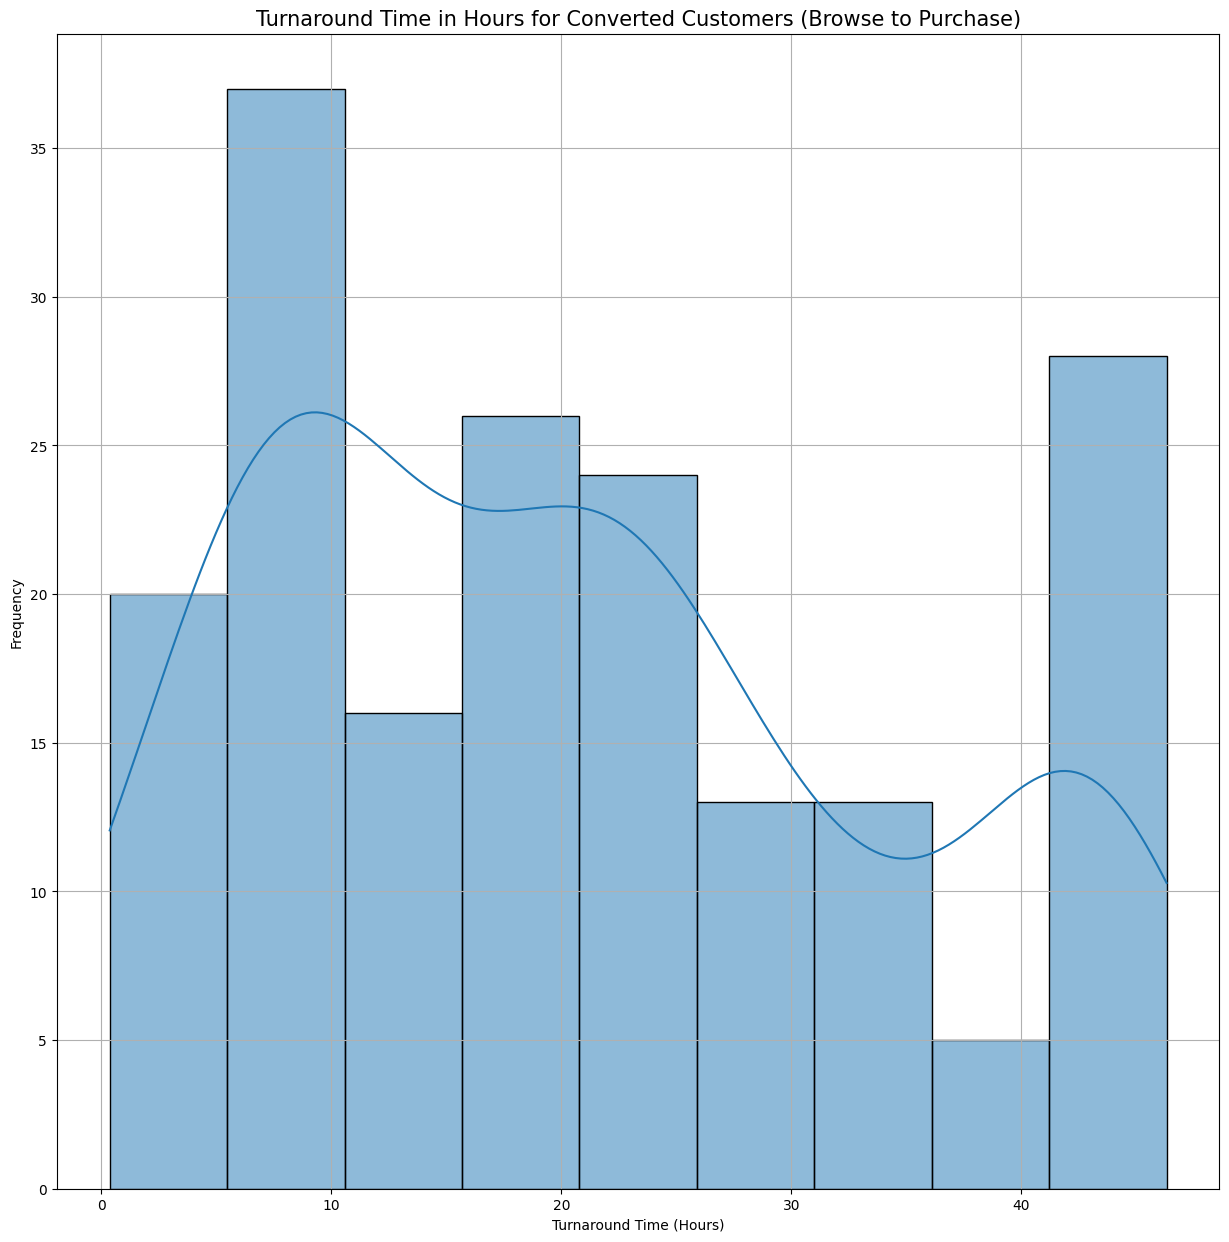

In [67]:
# Plot the distribution of turnaround time for converted customers
plt.figure(figsize = (15, 15))
sns.histplot(conv_cust.loc[:, 'Turnaround_Time_Hours'], kde = True)
plt.title('Turnaround Time in Hours for Converted Customers (Browse to Purchase)', fontsize = 15)
plt.xlabel('Turnaround Time (Hours)')
plt.ylabel('Frequency')
plt.grid();

From the above plot, we can see that the **conversion time** from browsing to purchase does not follow a normal distribution, indicating that the shoppers are completely random in deciding whether the product they have is suitable to their needs in the sense that they need to ask around for reviews on the product *or* the service that comes with order fulfilment, such as delivery delays, returns and replacements, payment issues, etc.

The customers seem to have no specific urgency in purchasing the product either. Though majority of the customers do tend to close the purchase within $12$ hours, while also having a good proportion of the customers waiting for a day before doing so as well. However, what is surprising is that many customers are also willing to wait between $40$ and $48$ hours before closing the deal, indicating that the customers may also be **waiting for better deals** in according with the concept of *Everyday Low Pricing*, where random products are suddenly given sales discounts to ensure high movements of medium or low-velocity stock.

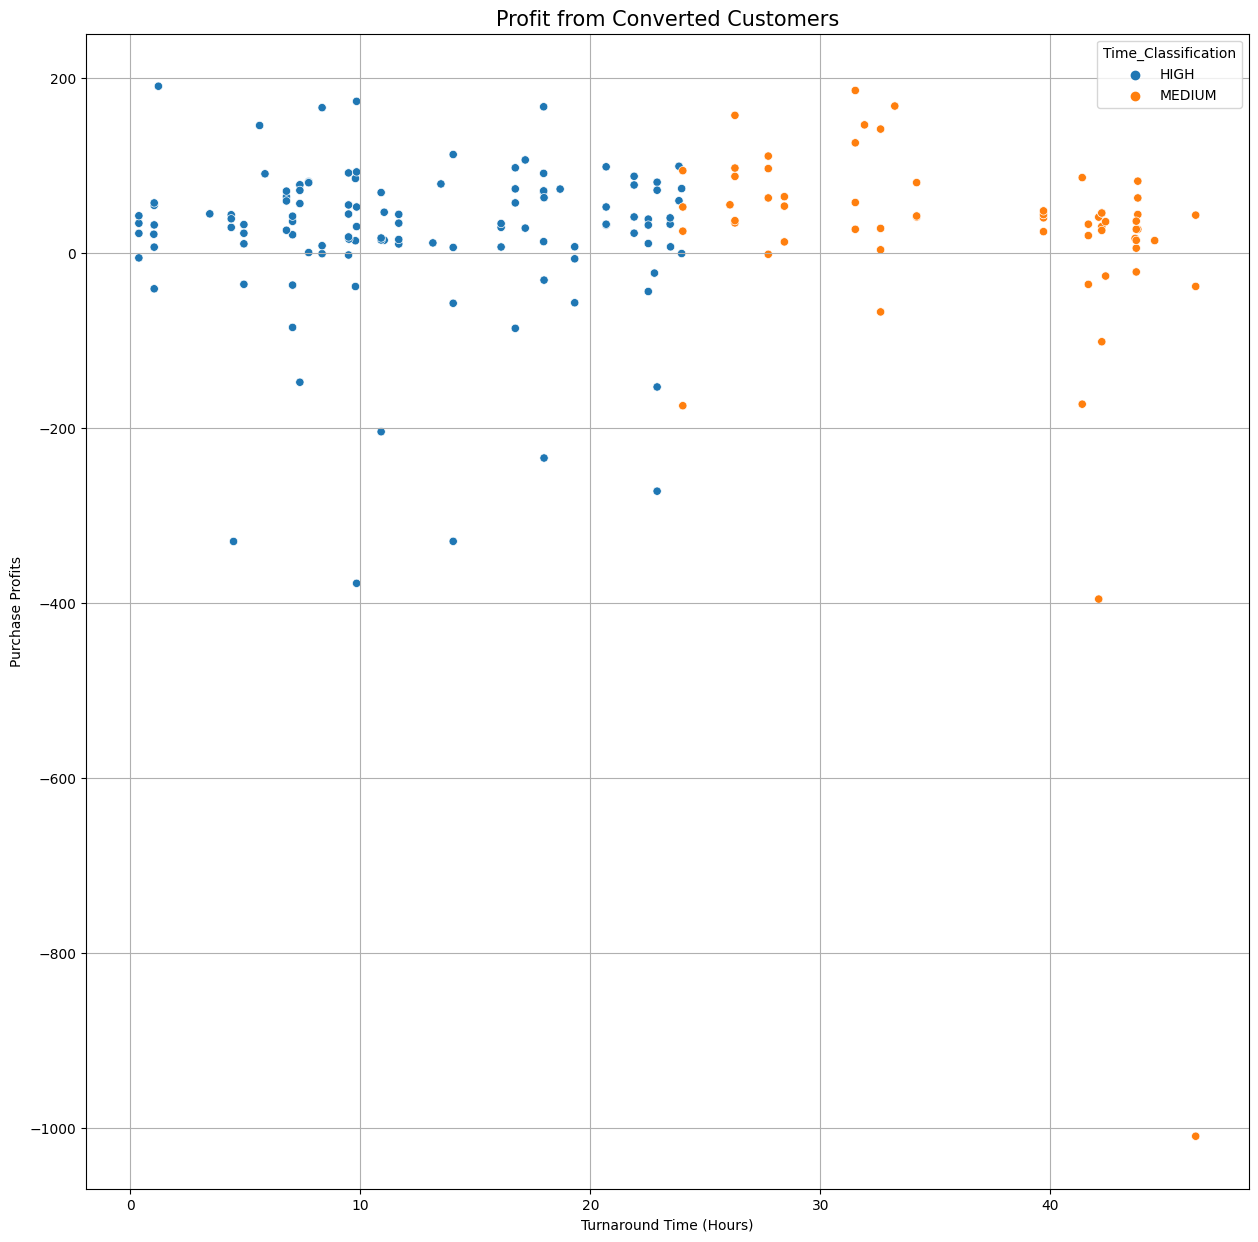

In [68]:
# Map the turnaround time of the converted customers to Purchase profit
plt.figure(figsize = (15, 15))
sns.scatterplot(data = conv_cust, x = conv_cust.loc[:, 'Turnaround_Time_Hours'],
                y = conv_cust.loc[:, 'Benefit_per_order'], 
                hue = conv_cust.loc[:, 'Time_Classification'])
plt.title('Profit from Converted Customers', fontsize = 15)
plt.xlabel('Turnaround Time (Hours)')
plt.ylabel('Purchase Profits')
plt.grid();

As a prelimary EDA, we can also observe the impact of such customers on the profits generated from such sales, and see if the company is losing any money in costs to convert such customers. From the above scenario, we can see that almost $80\%$ of such customers consistently bring in profits, meaning despite having no (assumed) marketing campaigns in place, the company is doing a fairly good job of converting such customers to purchases. Remember, we also saw that $\approx{7.88}\%$ of browsing customers converted to purchases by simply looking for deals; it is evident that stage-wise marketing campaigns can be carried out to increase this conversion footprint, such as deep-discounts for repeat purchases within a time-frame, cashback or other such reward protocols for newly converted customers to encourage repeat purchases, among others.

This is just based on the assumption that purchases shown here are the status quo, and no marketing has been initiated for increasing footprint.

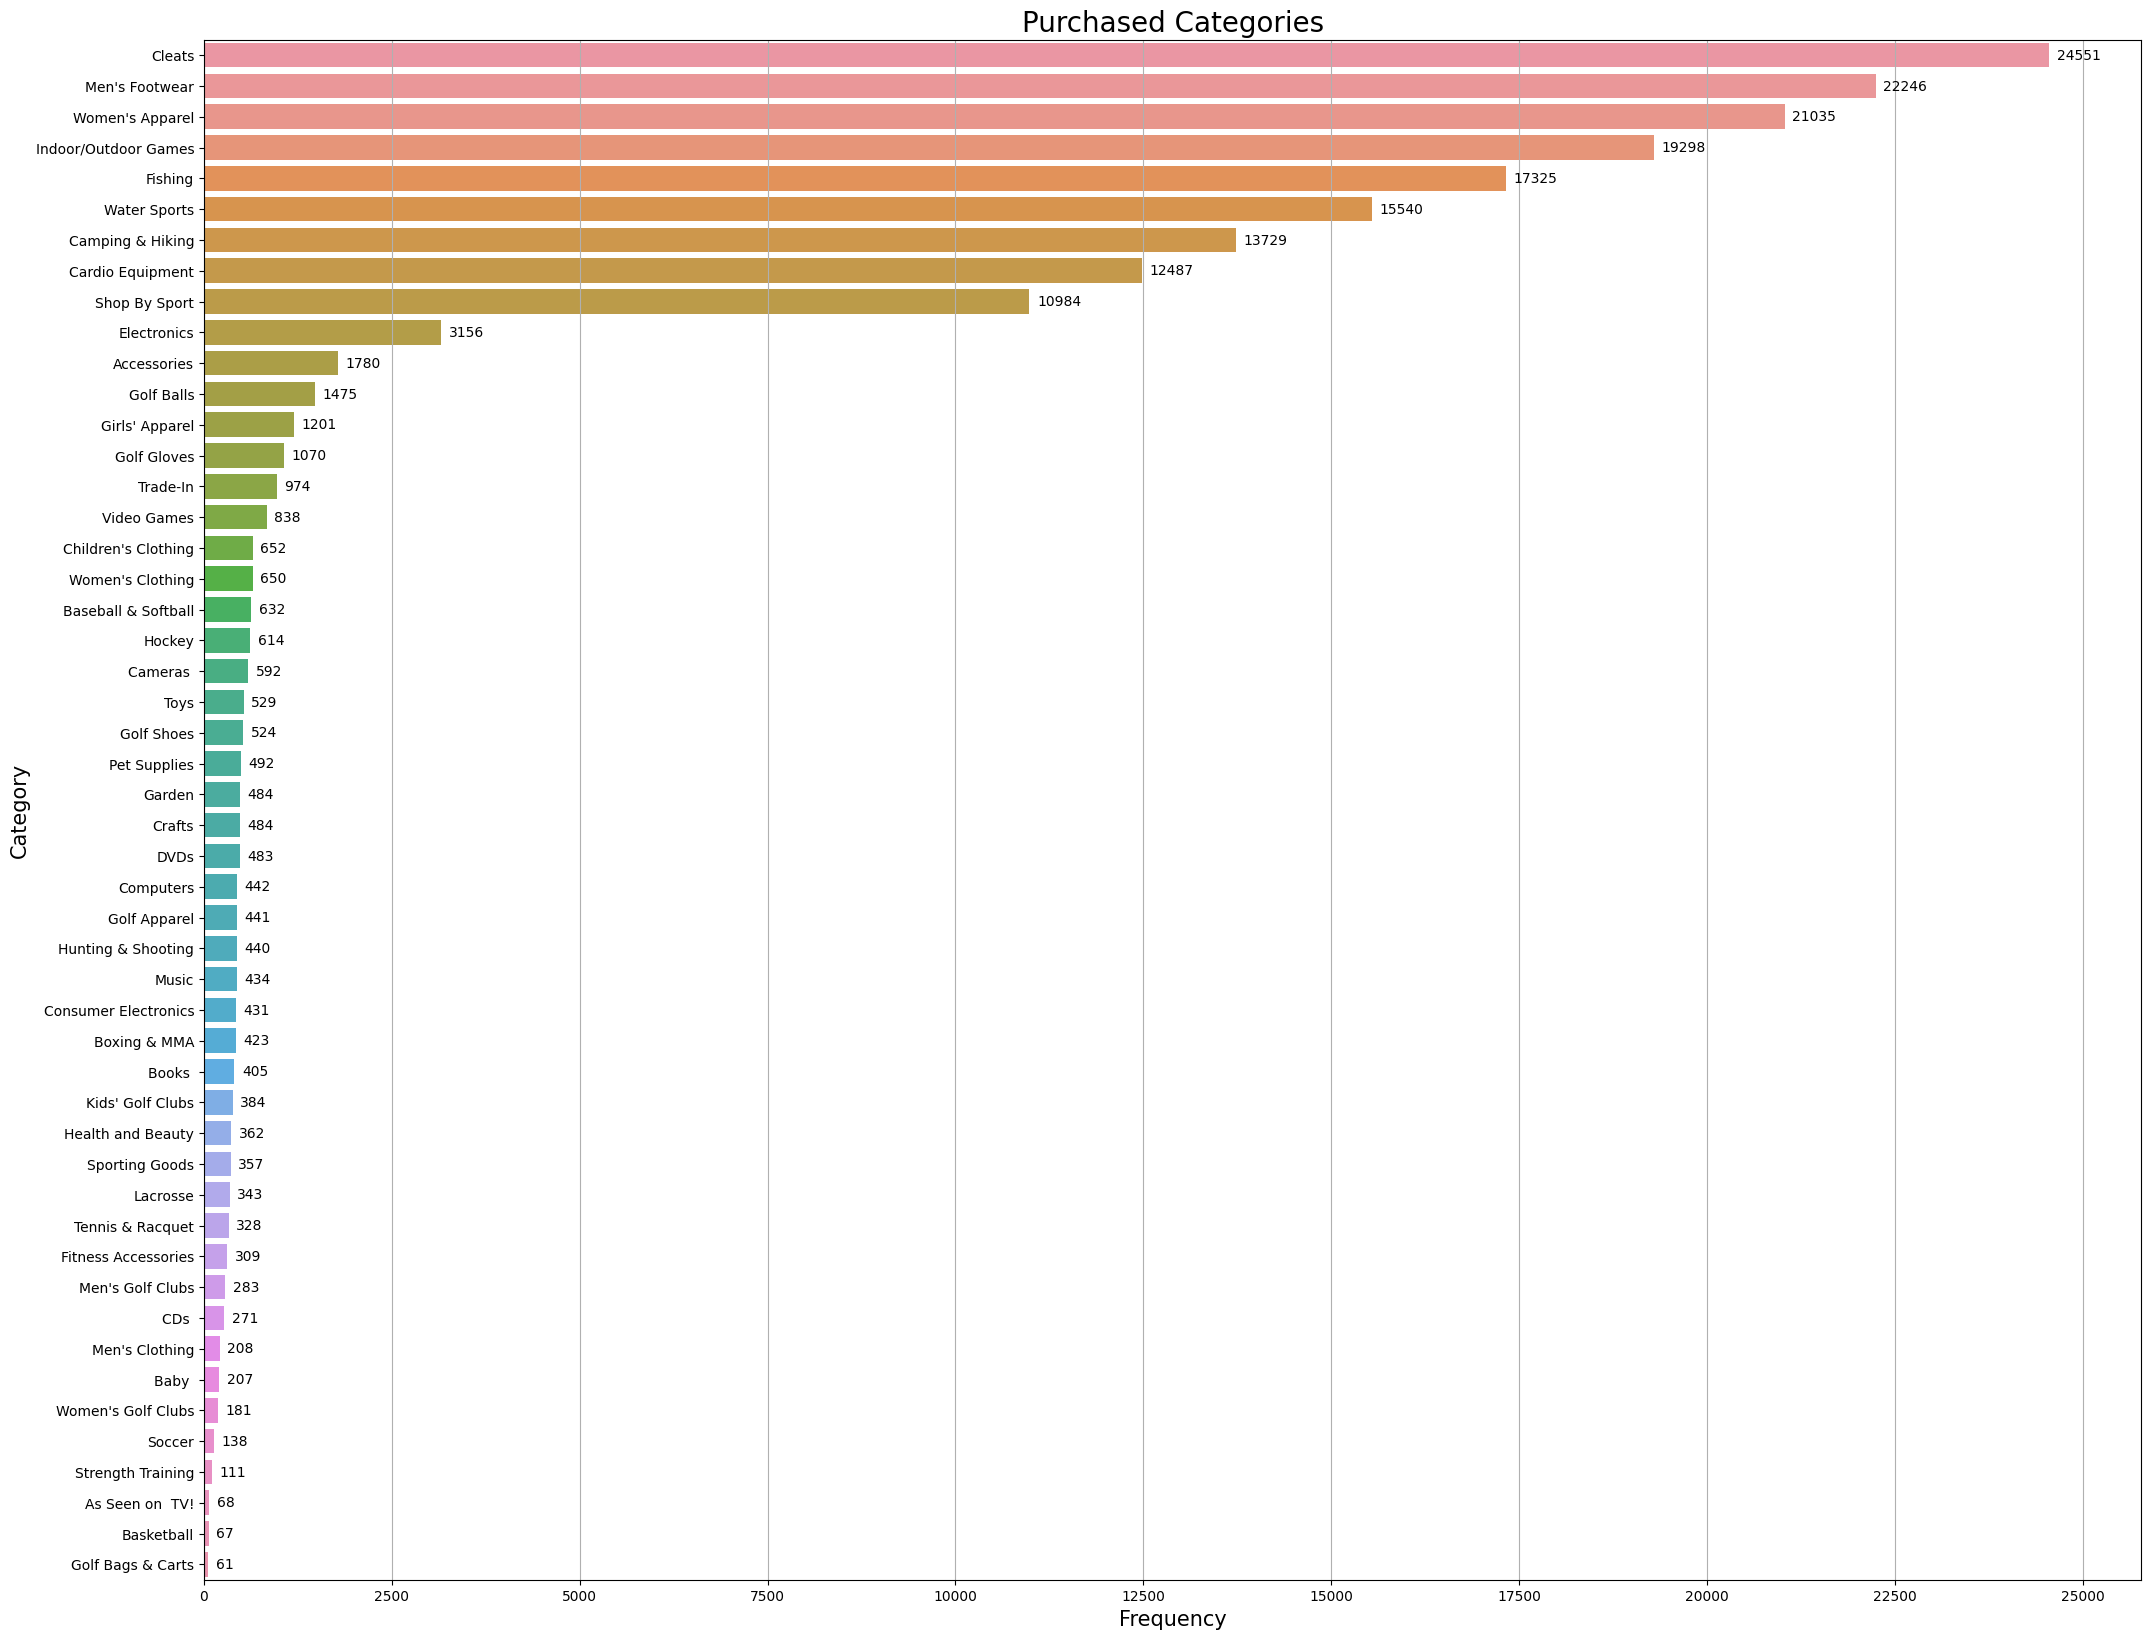

In [69]:
# Extract the values to sort the count plot
cat_count = cust_turn.loc[:, 'Category_Name'].value_counts()


# Check for Category distribution of the matched browsing data
plt.figure(figsize = (25, 20))
ax = sns.countplot(data=cust_turn, y = 'Category_Name', 
             order = cat_count.index)

# Annotate the plot
for bar in ax.patches:
    width = bar.get_width()  # Get the width of the bar
    ax.text(width + 100, bar.get_y() + bar.get_height() / 2,  # Position of the text
            f'{int(width)}', va='center')  # Add the count as text

# Increase the number of x-axis markers
plt.xticks(ticks=range(0, cust_turn.loc[:, "Category_Name"].value_counts().max() + 1000, 2500))

# Embellish the plot
plt.title('Purchased Categories', fontsize = 20)
plt.xlabel('Frequency', fontsize = 15)
plt.ylabel('Category', fontsize = 15)
plt.grid(axis='x')
plt.show()

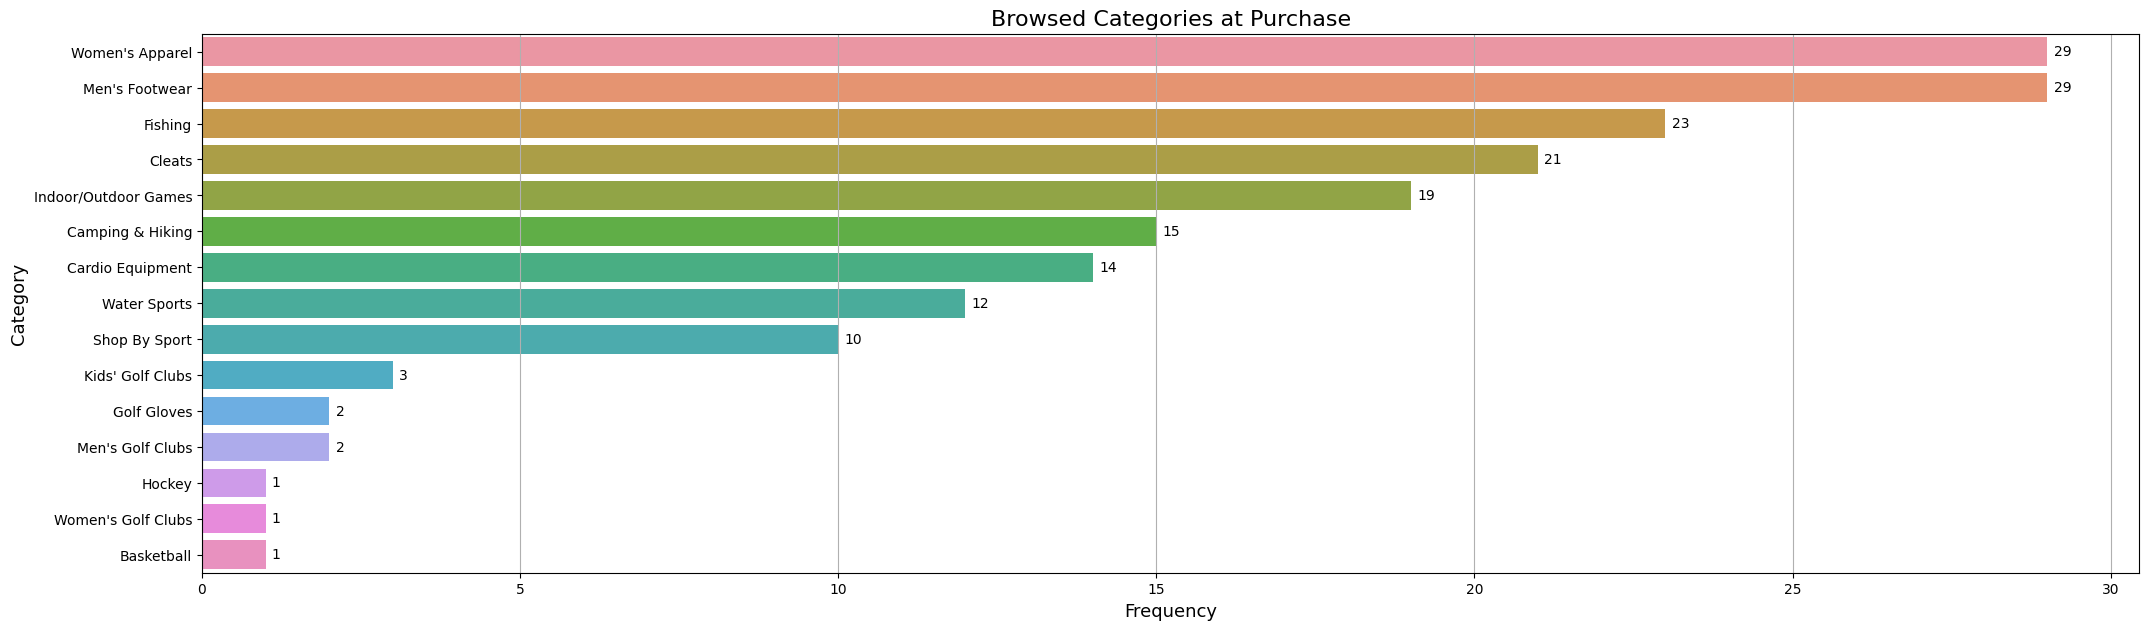

In [70]:
# Extract the values to sort the count plot
cat_count = conv_cust.loc[:, 'Category_Name'].value_counts()


# Check for Category distribution of the matched browsing data
plt.figure(figsize = (25, 7))
ax = sns.countplot(data=conv_cust, y = 'Category_Name', 
             order = cat_count.index)

# Annotate the plot
for bar in ax.patches:
    width = bar.get_width()  # Get the width of the bar
    ax.text(width + 0.1, bar.get_y() + bar.get_height() / 2,  # Position of the text
            f'{int(width)}', va='center')  # Add the count as text

# Embellish with title
plt.title('Browsed Categories at Purchase', fontsize = 16)
plt.xlabel('Frequency', fontsize = 13)
plt.ylabel('Category', fontsize = 13)
plt.grid(axis='x')
plt.show()

Finally, we can also look at the overall categories of the products that are being purchased by the total customer base as compared to the ones being purchased by converted customers. It is important to note that the top purchases of such a customer base has similar preference of products as direct purchasers, which lead further credence to the fact that the demographics doing the browsing may be of the same clusters as the direct purchasers, though this will need to be studied further with clustering analysis of the browsing logs. Another POV is that the low conversion rate from browsing logs to purchase may be because the store may not be having the required products for purchase, or the prices may be turning them away. These may also be obtained from analysisng the browsing behaviour as well as using other methods to map the browsing session logs to the purchases.

# **<u>CONCLUSION</u>**

## FILE CREATION

Now that we have created the merged dataset, we will go ahead and convert the pandas dataframe into an **SQL-compliant file format such as *.parquet*** which is said to be the most widely used format for large data storage. The characteristics of the file stores are as follows:

1. The engine used for the conversion is the in-built `pyarrow` engine, which is said to be among the most widely used format for Apache storage engines, and have higher number of features and feature operations supported.

2. The compression used will be the `Brotli` compression which is considered to have the high compression speeds, but a very good storage saving capability.

3. We will preserve the index of the dataset to ensure that in case the stakeholder wishes to see the dataset distribution as is, there is no loss of information integrity.


These conditions have been set in accordance with the core idea of storing the same as a GitHub project for showcasing the skills used in conducting this ETL project; GitHub repo's have a very small storage size limit, and cannot upload large file sizes otherwise seen with `Snap` compression.

In [71]:
# Store the complete merged data in acceptable format
cust_turn.to_parquet('/kaggle/working/merged_customer_behaviour.parquet',
                     engine = 'pyarrow', compression = 'brotli', index = True)

In [72]:
# Check if the data is stored as per requirements
df = pd.read_parquet('/kaggle/working/merged_customer_behaviour.parquet')
display(df)

,Type,Days_for_shipping_real,Days_for_shipment_scheduled,Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,Customer_Country,Customer_Email,Customer_Fname,Customer_Id,Customer_Lname,Customer_Password,Customer_Segment,Customer_State,Customer_Street,Customer_Zipcode,Department_Id,Department_Name,Latitude,Longitude,Market,Order_City,Order_Country,Order_Customer_Id,order_date_DateOrders,Order_Id,Order_Item_Cardprod_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Product_Price,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Item_Total,Order_Profit_Per_Order,Order_Region,Order_State,Order_Status,Product_Card_Id,Product_Category_Id,Product_Image,Product_Name,Product_Price,Product_Status,shipping_date_DateOrders,Shipping_Mode,purchase_lat,purchase_long,bound_south,bound_north,bound_west,bound_east,First_View_Timestamp,Total_Daily_Interactions,Browsing_Distance_km,Match_Found,Time_Classification,Turnaround_Time
0,DEBIT,3,4,91.2500,314.6400,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0000,2,Fitness,18.2515,-66.0371,Pacific Asia,Bekasi,Indonesia,20755,2018-01-31 22:56:00,77202,1360,13.1100,0.0400,180517,327.7500,0.2900,1,327.7500,314.6400,91.2500,Southeast Asia,Java Occidental,COMPLETE,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-02-03 22:56:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,2018-01-31 22:56:00,0,0.0000,False,FOCUSED,0 days
1,TRANSFER,5,4,-249.0900,311.3600,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0000,2,Fitness,18.2795,-66.0371,Pacific Asia,Bikaner,India,19492,2018-01-13 12:27:00,75939,1360,16.3900,0.0500,179254,327.7500,-0.8000,1,327.7500,311.3600,-249.0900,South Asia,Rajastán,PENDING,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-18 12:27:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,2018-01-13 12:27:00,0,0.0000,False,FOCUSED,0 days
2,CASH,4,4,-247.7800,309.7200,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0000,2,Fitness,37.2922,-121.8813,Pacific Asia,Bikaner,India,19491,2018-01-13 12:06:00,75938,1360,18.0300,0.0600,179253,327.7500,-0.8000,1,327.7500,309.7200,-247.7800,South Asia,Rajastán,CLOSED,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-17 12:06:00,Standard Class,37.3362,-121.8906,37.1232,37.4691,-122.0462,-121.5858,2018-01-13 12:06:00,0,0.0000,False,FOCUSED,0 days
3,DEBIT,3,4,22.8600,304.8100,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0000,2,Fitness,34.1259,-118.2910,Pacific Asia,Townsville,Australia,19490,2018-01-13 11:45:00,75937,1360,22.9400,0.0700,179252,327.7500,0.0800,1,327.7500,304.8100,22.8600,Oceania,Queensland,COMPLETE,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-16 11:45:00,Standard Class,34.0537,-118.2428,33.6595,34.3373,-118.6682,-118.1553,2018-01-13 11:45:00,0,0.0000,False,FOCUSED,0 days
4,PAYMENT,2,4,134.2100,298.2500,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0000,2,Fitness,18.2538,-66.0370,Pacific Asia,Townsville,Australia,19489,2018-01-13 11:24:00,75936,1360,29.5000,0.0900,179251,327.7500,0.4500,1,327.7500,298.2500,134.2100,Oceania,Queensland,PENDING_PAYMENT,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.7500,0,2018-01-15 11:24:00,Standard Class,18.2129,-66.0559,18.1136,18.3125,-66.1179,-65.9976,2018-01-13 11:24:00,0,0.0000,False,FOCUSED,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

With this project, we have demonstrated our abilities to carry out analysis of datasets in order to make it ready for analysis, despite having no obvious primary connection columns, and also showcasing our ability to infer the connections between the datasets, with the caveats of making assumptions from the limited information available to work with the project.